# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this project am going to classify the traffic signs from the [German Traffic Sign Benchmarks](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

I'm using the scikit-learn's framework in order to train the model.

The project is explained in the following sections.

- Data Exploratory Analysis
- Model Implementation
- Pipeline Implementation
- Preprocessing
- Model Improvement
- Testing and Results

---
## Data Exploratory Analysis
The traffic sign images were taken from the German Traffic Sign Benchmarks.

http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Training_Images.zip
http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_Images.zip
http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_GT.zip

In [2]:
import glob
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from pipeline import NeuralNetwork, make_adam, Session, build_pipeline

matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

---

## Load Training Data

All training images path are combined into a dataframe.

In [3]:
TRAIN_IMAGES_DIR = 'data/Final_Training/Images'
dfs = []
for trainfile in glob.glob(os.path.join(TRAIN_IMAGES_DIR, '*/GT-*.csv')):
    folder = trainfile.replace('\\','/').split('/')[3]
    df = pd.read_csv(trainfile, sep=';')
    df['Filename'] = df['Filename'].apply(lambda x: os.path.join(TRAIN_IMAGES_DIR, folder, x))
    dfs.append(df)

In [4]:
traindf = pd.concat(dfs,ignore_index=True)
traindf.head()

Filename  Width  Height  Roi.X1  \
0  data/Final_Training/Images/00026/00000_00000.ppm     30      29       6   
1  data/Final_Training/Images/00026/00000_00001.ppm     30      29       5   
2  data/Final_Training/Images/00026/00000_00002.ppm     30      31       5   
3  data/Final_Training/Images/00026/00000_00003.ppm     32      31       6   
4  data/Final_Training/Images/00026/00000_00004.ppm     32      32       6   

   Roi.Y1  Roi.X2  Roi.Y2  ClassId  
0       6      25      24       26  
1       5      25      24       26  
2       6      25      25       26  
3       5      27      26       26  
4       6      27      27       26

**Annotation format**
- Filename: Filename of corresponding image
- Width: Width of the image
- Height: Height of the image
- ROI.x1: X-coordinate of top-left corner of traffic sign bounding box
- ROI.y1: Y-coordinate of top-left corner of traffic sign bounding box
- ROI.x2: X-coordinate of bottom-right corner of traffic sign bounding box
- ROI.y2: Y-coordinate of bottom-right corner of traffic sign bounding box
- ClassId: Assigned class label


## Classes
Number of traffic sign classes

In [5]:
N_CLASSES = np.unique(traindf['ClassId']).size

print("Nr of training images: "+str(traindf.shape[0]))
print("Nr of classes        : "+str(N_CLASSES))

Nr of training images: 39209
Nr of classes        : 43


### Plot traffic sign class distribuition


In [6]:
def show_class_distribuition(class_ids,title):
    plt.figure(figsize=(15,5))
    plt.title('Class ID distribuition for {}'.format(title))
    plt.hist(class_ids, bins=N_CLASSES)
    plt.show()

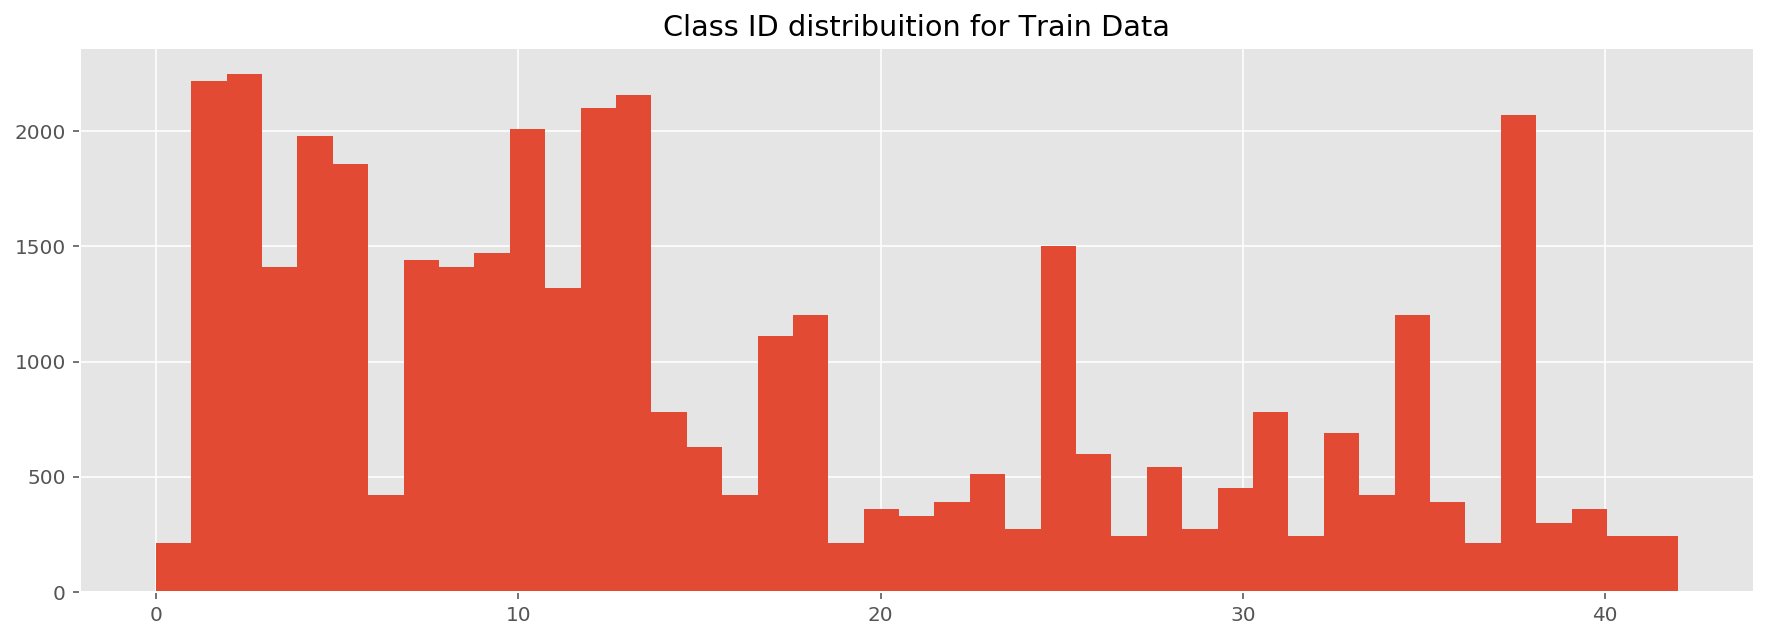

In [7]:
show_class_distribuition(traindf['ClassId'], 'Train Data')

Sign names are stored in sign_names.csv file. We will use it to see distribuition by sign names.

In [8]:
signname_df = pd.read_csv('signnames.csv', index_col='ClassId')
signname_df.head()

SignName
ClassId                      
0        Speed limit (20km/h)
1        Speed limit (30km/h)
2        Speed limit (50km/h)
3        Speed limit (60km/h)
4        Speed limit (70km/h)

In [33]:
signname_df['Occurence'] = [sum(traindf['ClassId']==c) for c in range(N_CLASSES)]
signname_df.sort_values('Occurence', ascending=False)

SignName  Occurence
ClassId                                                              
2                                     Speed limit (50km/h)       2250
1                                     Speed limit (30km/h)       2220
13                                                   Yield       2160
12                                           Priority road       2100
38                                              Keep right       2070
10            No passing for vehicles over 3.5 metric tons       2010
4                                     Speed limit (70km/h)       1980
5                                     Speed limit (80km/h)       1860
25                                               Road work       1500
9                                               No passing       1470
7                                    Speed limit (100km/h)       1440
3                                     Speed limit (60km/h)       1410
8                                    Speed limit (120km/h)       1410
11                   Right-of-way at the next intersection       1320
35                                              Ahead only       1200
18                                         General caution       1200
17                                                No entry       1110
31                                   Wild animals crossing        780
14                                                    Stop        780
33                                        Turn right ahead        689
15                                             No vehicles        630
26                                         Traffic signals        600
28                                       Children crossing        540
23                                           Slippery road        510
30                                      Beware of ice/snow        450
16                Vehicles over 3.5 metric tons prohibited        420
34                                         Turn left ahead        420
6                              End of speed limit (80km/h)        420
36                                    Go straight or right        390
22                                              Bumpy road        390
40                                    Roundabout mandatory        360
20                            Dangerous curve to the right        360
21                                            Double curve        330
39                                               Keep left        300
29                                       Bicycles crossing        270
24                               Road narrows on the right        270
41                                       End of no passing        240
42       End of no passing by vehicles over 3.5 metric ...        240
32                     End of all speed and passing limits        240
27                                             Pedestrians        240
37                                     Go straight or left        210
19                             Dangerous curve to the left        210
0                                     Speed limit (20km/h)        210

Define constants to use later.

In [9]:
SIGN_NAMES = signname_df.SignName.values
SIGN_NAMES[4]

'Speed limit (70km/h)'

In [10]:
## Sample Images

def load_image(file):
    return plt.imread(file)

def get_samples(image_data, no_samples, class_id=None):
    """
    Random image selection inclusive the class ids
    """
    if class_id is not None:
        image_data = image_data[image_data['ClassId'] ==class_id]
    indexes = np.random.choice(image_data.shape[0],size=no_samples, replace=False)
    return image_data.iloc[indexes][['Filename', 'ClassId']].values

def show_images(image_data, cols=5, sign_names=None, show_shape=False, func=None):
    """
    Given a list of image file paths, load images and show them.
    """
    num_images = len(image_data)
    rows = num_images//cols
    plt.figure(figsize=(cols*3,rows*2.5))
    for i, (image_file, label) in enumerate(image_data):
        image = load_image(image_file)
        if func is not None:
            image = func(image)
        plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        if sign_names is not None:
            plt.text(0, 0, '{}: {}'.format(label, sign_names[label]), color='k',backgroundcolor='c', fontsize=8)        
        if show_shape:
            plt.text(0, image.shape[0], '{}'.format(image.shape), color='k',backgroundcolor='y', fontsize=8)        
        plt.xticks([])
        plt.yticks([])
    plt.show()

Lets show 15 random images

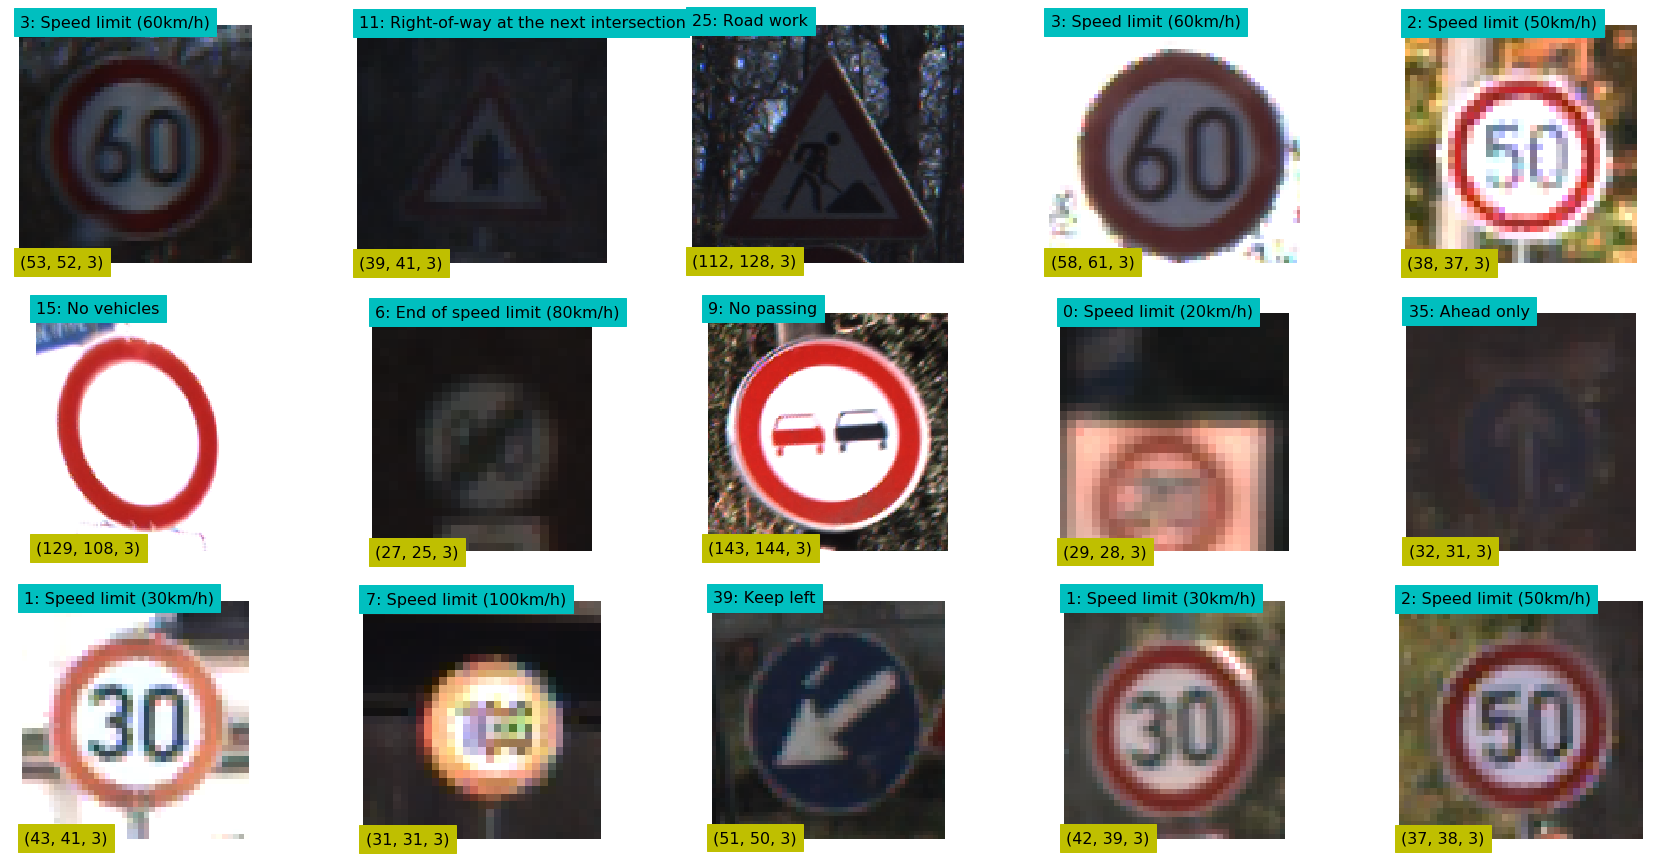

In [11]:
sample_data = get_samples(traindf,15)
show_images(sample_data, sign_names=SIGN_NAMES, show_shape=True)

Speed limit (50km/h)


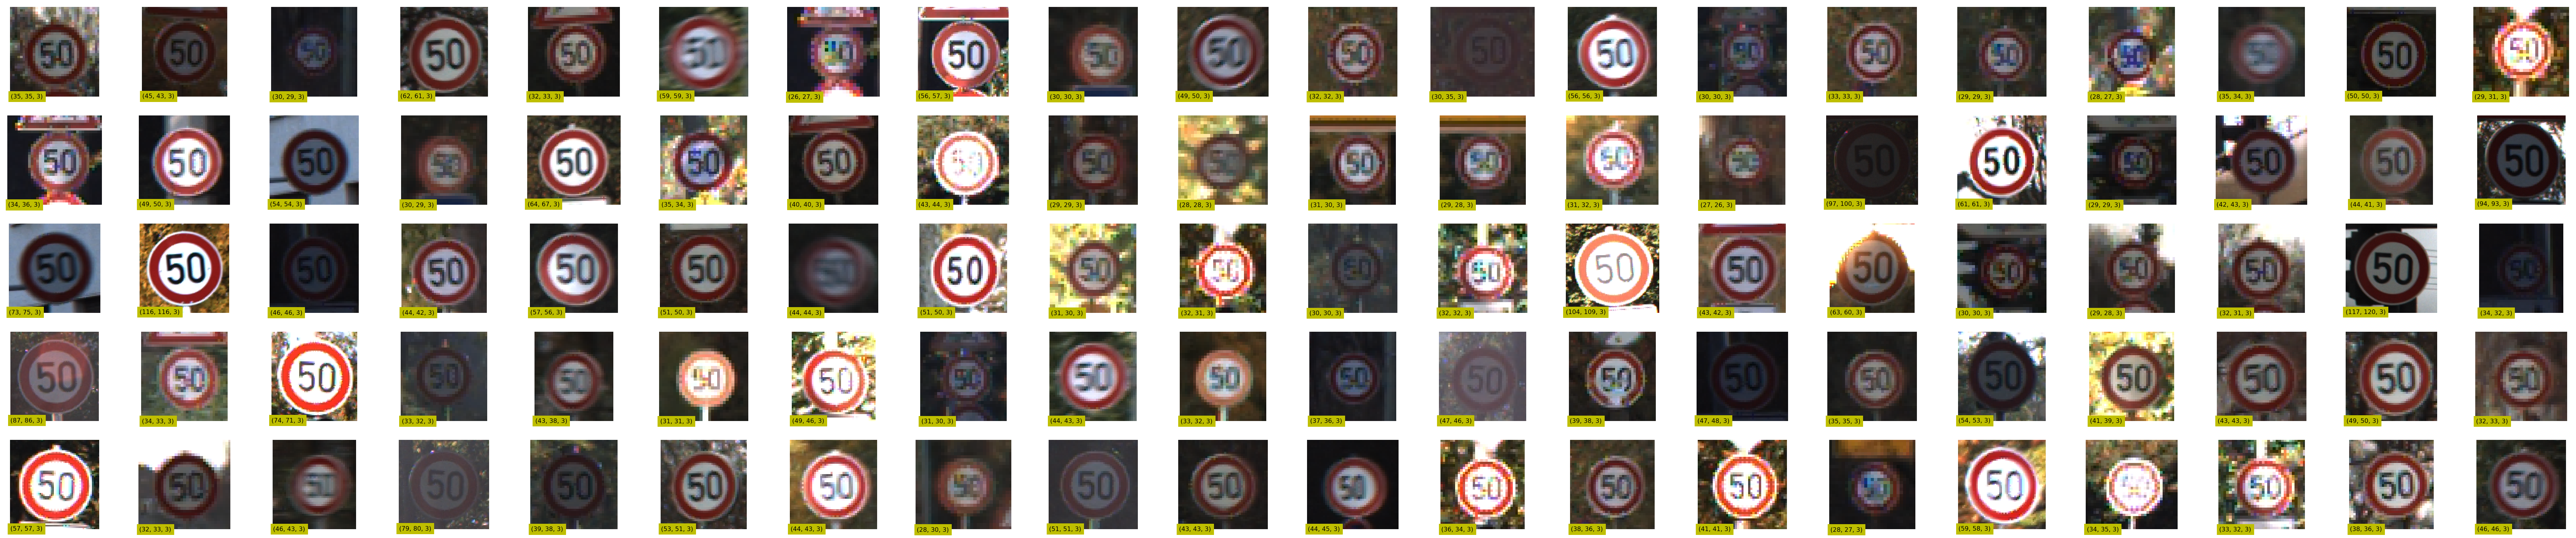

In [12]:
print(SIGN_NAMES[2])
show_images(get_samples(traindf, 100, class_id=2), cols=20, show_shape=True)

Looking at the sample images, we can conclude they:

- have different sizes  
- have random darkness / brightness
- be slightly rotated
- may not be facing straight
- may not be centered
  
Based on that, we start pre-processing them, and then we will augment them.

## Train and Validation Data Set
Train and validation data set are created from training data

In [13]:
X  = traindf['Filename'].values
y = traindf['ClassId'].values

print('X data', len(X))

X data 39209


In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=8000, random_state=0)

print('X_train: ', len(X_train))
print('X_valid: ', len(X_valid))

X_train:  31209
X_valid:  8000


# Model Implementation
## Model Architecture

The model is based on [LeNet](http://yann.lecun.com/exdb/lenet/) by Yann LeCun.  It is a convolutional neural network designed to recognize visual patterns directly from pixel images with minimal preprocessing.  It can handle hand-written characters very well. 

![LeNet](images/lenet.png)

Source: http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf

- The inputs are 32x32 (Black-White 1 channel) images
- LeNet uses 2x2 sub-sampling (valid padding, max pooling) in convolutional layers (no dropout)
- LeNet uses a sigmoid squashing function - a scaled hyperbolic tangent: $Atanh(Sa)$ where A=1.7159 and S=2/3
- LeNet has one 7x12 bitmap for each class, which is a label.  There are 10 classes (the digits '0' - '9')
- 7x12 = 84 which is why the output is 84
- The output is compared with all the labels (bitmaps) to calculate the error
- The class with the smallest error is an estimated digit value

Our model is adapted from the LeNet as follows.  

- The inputs are 32x32 (RGB - 3 channels) images
- The activation function is ReLU except for the output layer which uses Softmax
- The output has 43 classes

|Layer                       | Shape    |
|----------------------------|:--------:|
|Input                       | 32x32x3  |
|Convolution (valid, 5x5x6)  | 28x28x6  |
|Max Pooling (valid, 2x2)    | 14x14x6  |
|Activation  (ReLU)          | 14x14x6  |
|Convolution (valid, 5x5x16) | 10x10x16 |
|Max Pooling (valid, 2x2)    | 5x5x16   |
|Activation  (ReLU)          | 5x5x16   |
|Flatten                     | 400      |
|Dense                       | 120      |
|Activation  (ReLU)          | 120      |
|Dense                       | 43       |
|Activation  (Softmax)       | 43       |

## Model Implementation

The NeuralNetwork class is defined to provide common operations in neural network using Tensorflow.  See the network.py for details.


The network is based on LeNet

In [15]:
INPUT_SHAPE = (32,32,3)

In [16]:

def make_net(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
           .input(input_shape)
           .conv([5,5,6])
           .max_pool().relu()
           .conv([5,5,16])
           .max_pool()
           .relu().flatten().dense(120).relu().dense(N_CLASSES)
           )

## Pipeline implementation

Our pipeline is trained and evaluated by the following function

In [17]:
def train_eval(pipeline, epochs=5, samples_per_epoch=50000, train=(X_train, y_train), test=(X_valid, y_valid)):
    """
    Train and evaluate performance
    Return:
        Array of (epochs, train scores, eval scores)
    """
    X, y = train
    learning_curve = []
    for i in range(epochs):
        indexes = np.random.choice(len(X), size=samples_per_epoch)
        pipeline.fit(X[indexes],y[indexes])
        scores = [pipeline.score(*train), pipeline.score(*test)]
        learning_curve.append([i, *scores])
        print("Epoch: {:>} Train Score: {:.3f} Evaluation Score: {:.3f}".format(i, *scores))
    return np.array(learning_curve).T
        

In [18]:
def resize_image(image, shape=INPUT_SHAPE[:2]):
    return cv2.resize(image, shape)

loader = lambda image_file: resize_image(load_image(image_file))

In [ ]:
with Session() as session:
    functions = [loader]
    pipeline = build_pipeline(functions, session, make_net(), make_adam(1.0e-3))
    train_eval(pipeline)

Epoch: 0 Train Score: 0.855 Evaluation Score: 0.839
Epoch: 1 Train Score: 0.938 Evaluation Score: 0.919
Epoch: 2 Train Score: 0.947 Evaluation Score: 0.924
Epoch: 3 Train Score: 0.961 Evaluation Score: 0.936
Epoch: 4 Train Score: 0.963 Evaluation Score: 0.939


**Preliminary conclusion**:

This proves the network is working properly.  The performance is pretty good for the barebone network.

I can see a bit of overfitting.  This is likely because the network is exposed to the same images over and over since I'm using 5 epochs (50K samples per epoch).  At this moment, it is good to see the network is able to overfit and not showing high biases.  The network can handle these images and able to learn from the data.

# Preprocessing
## Image Augmentation

If we increase the number of epochs or samples per epoch, the network will overfit to the training set.  Hence, we should generate more training data using image augmentation.

In [20]:
def rand_brightness(image, ratio):
    """
    Adjust brightness of the image randomly.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    brightness = np.float64(hsv[:, :, 2])
    brightness = brightness * (1.0 + np.random.uniform(-ratio, ratio))
    brightness[brightness>255] = 255
    brightness[brightness<0] = 0
    hsv[:, :, 2] = brightness
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)


def rand_rotation(image, angle):
    """
    Rotate the image randomly
    """
    if angle == 0:
        return image
    angle = np.random.uniform(-angle, angle)
    rows, cols = image.shape[:2]
    size = cols, rows
    center = cols/2, rows/2
    scale = 1.0
    rotation = cv2.getRotationMatrix2D(center, angle, scale)
    return cv2.warpAffine(image, rotation, size)


def rand_translation(image, translation):
    """
    Move the image randomly
    """
    if translation == 0:
        return 0
    rows, cols = image.shape[:2]
    size = cols, rows
    x = np.random.uniform(-translation, translation)
    y = np.random.uniform(-translation, translation)
    trans = np.float32([[1,0,x],[0,1,y]])
    return cv2.warpAffine(image, trans, size)


def rand_shear(image, shear):
    """
    Distort the image randomly
    """
    if shear == 0:
        return image
    rows, cols = image.shape[:2]
    size = cols, rows
    left, right, top, bottom = shear, cols - shear, shear, rows - shear
    dx = np.random.uniform(-shear, shear)
    dy = np.random.uniform(-shear, shear)
    p1 = np.float32([[left   , top],[right   , top   ],[left, bottom]])
    p2 = np.float32([[left+dx, top],[right+dx, top+dy],[left, bottom+dy]])
    move = cv2.getAffineTransform(p1,p2)
    return cv2.warpAffine(image, move, size)
    
    
def augment_image(image, brightness, angle, translation, shear):
    image = rand_brightness(image, brightness)
    image = rand_rotation(image, angle)
    image = rand_translation(image, translation)
    image = rand_shear(image, shear)
    return image

In [21]:
augmenter = lambda x: augment_image(x, brightness=0.7, angle=10, translation=5, shear=2)

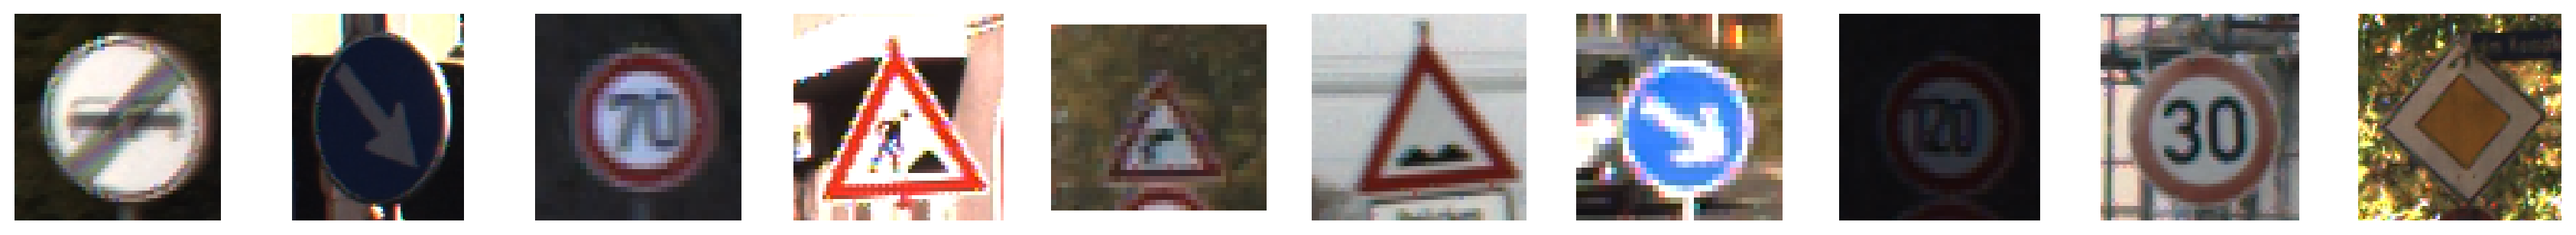

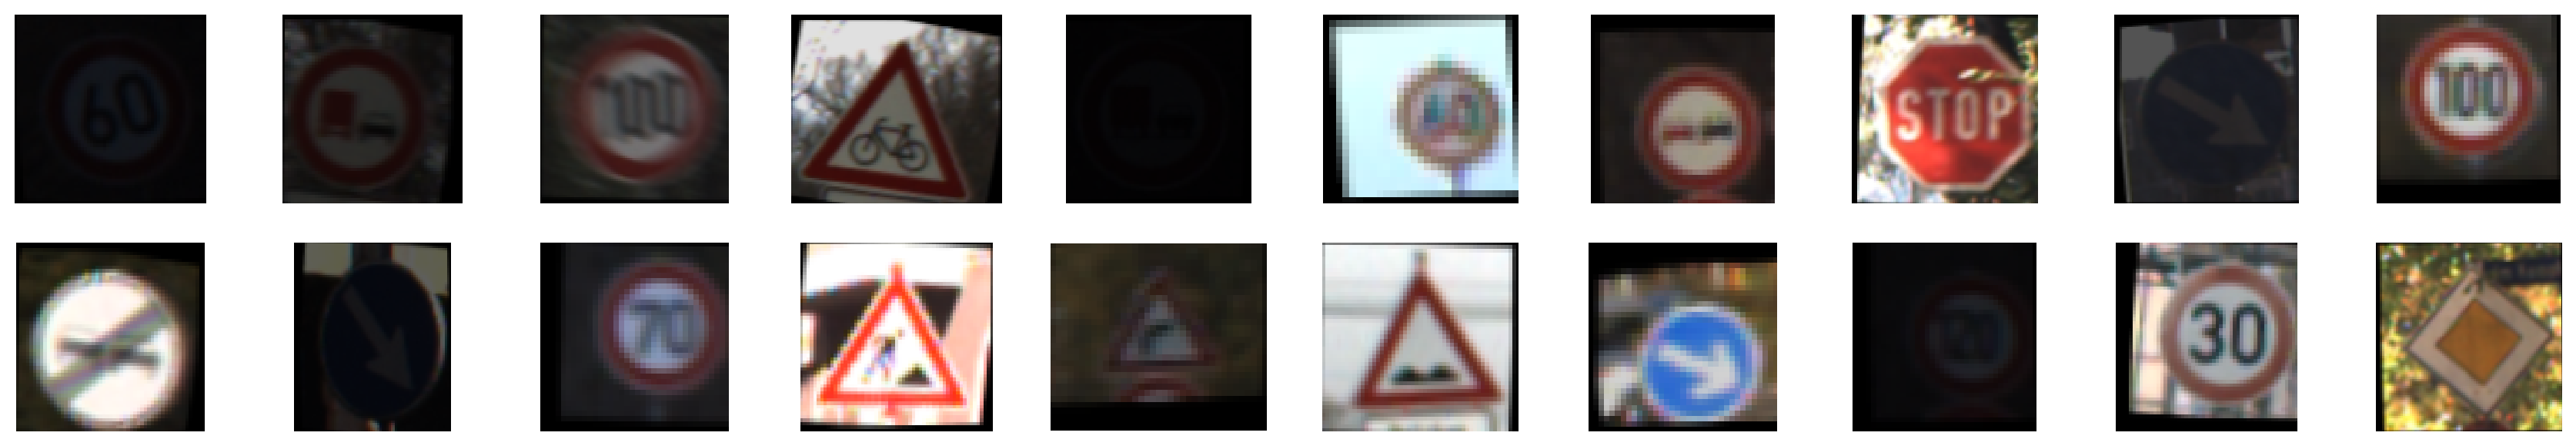

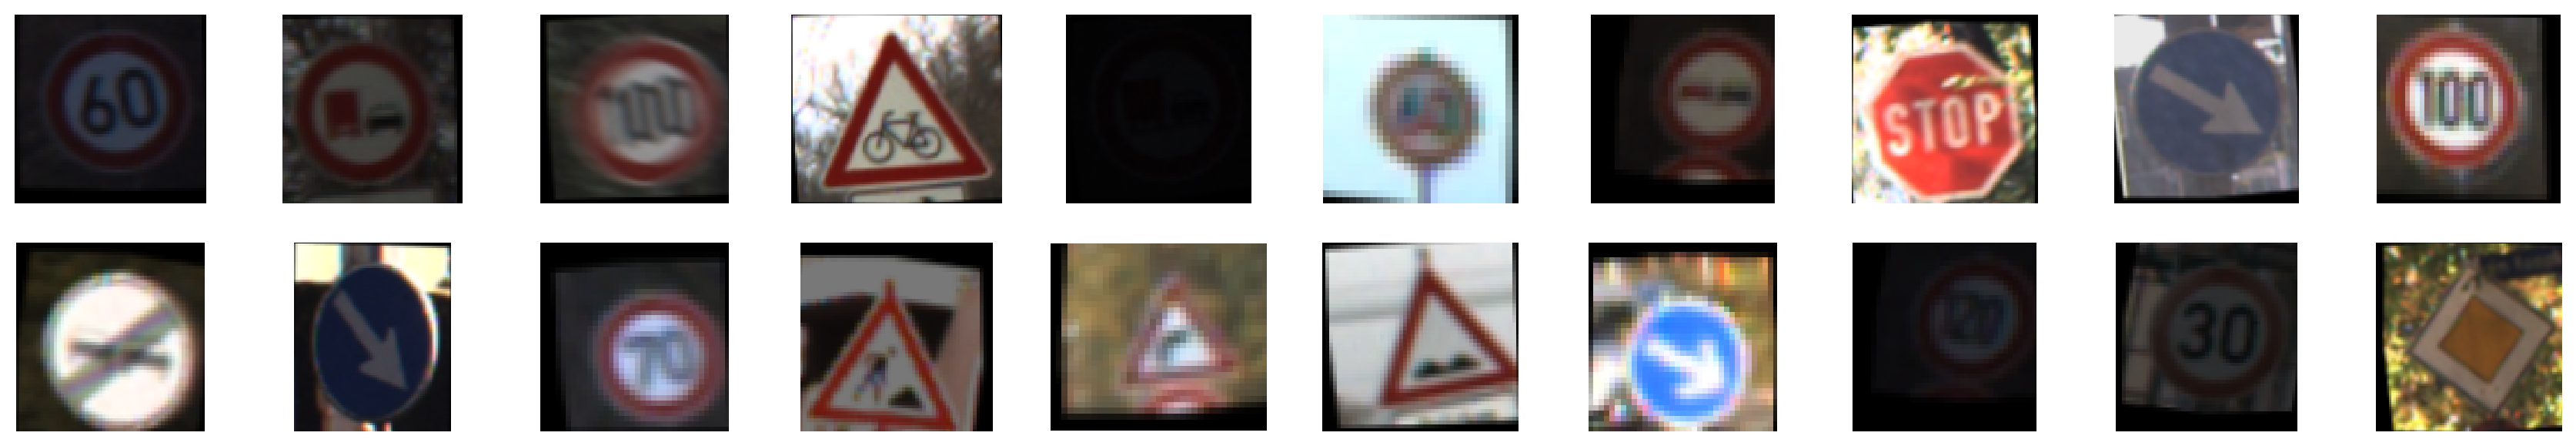

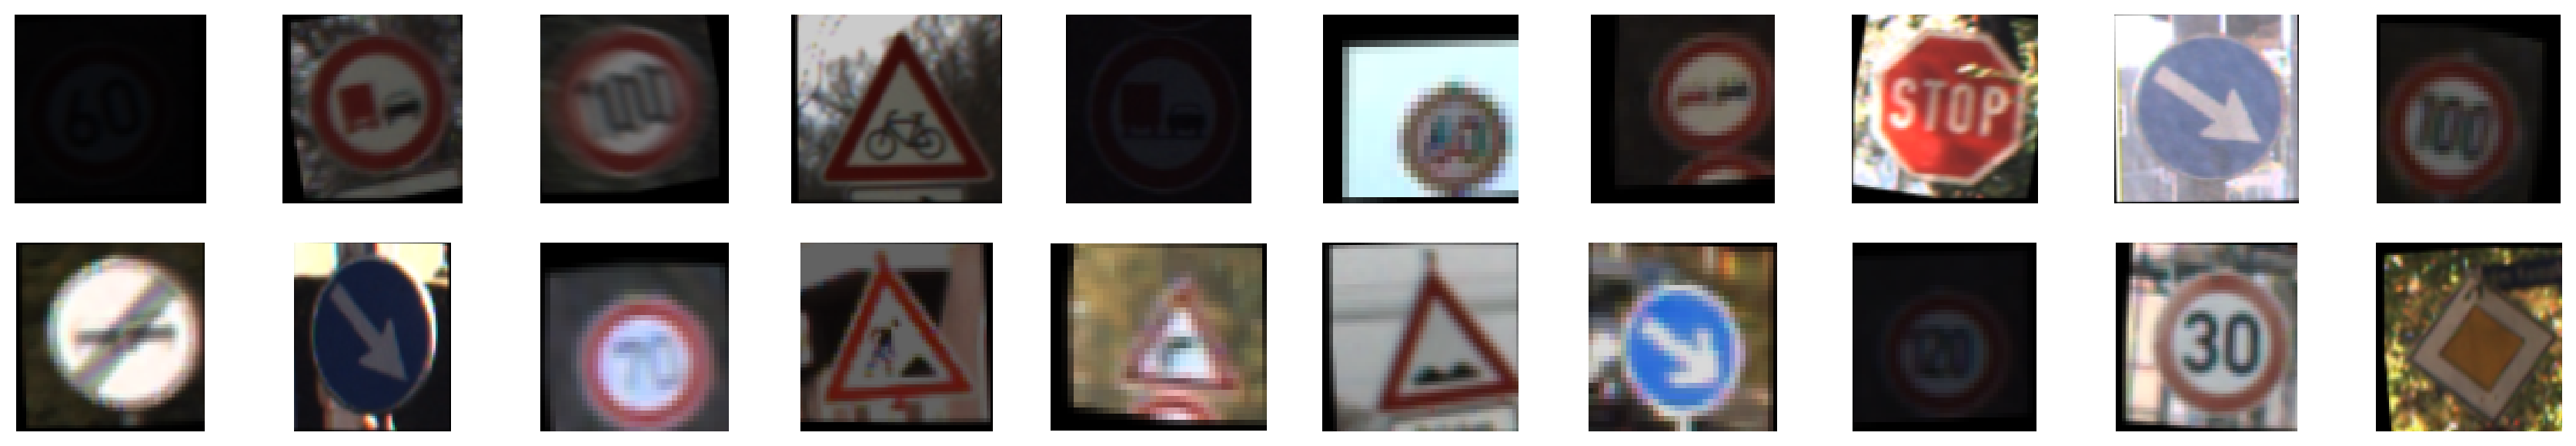

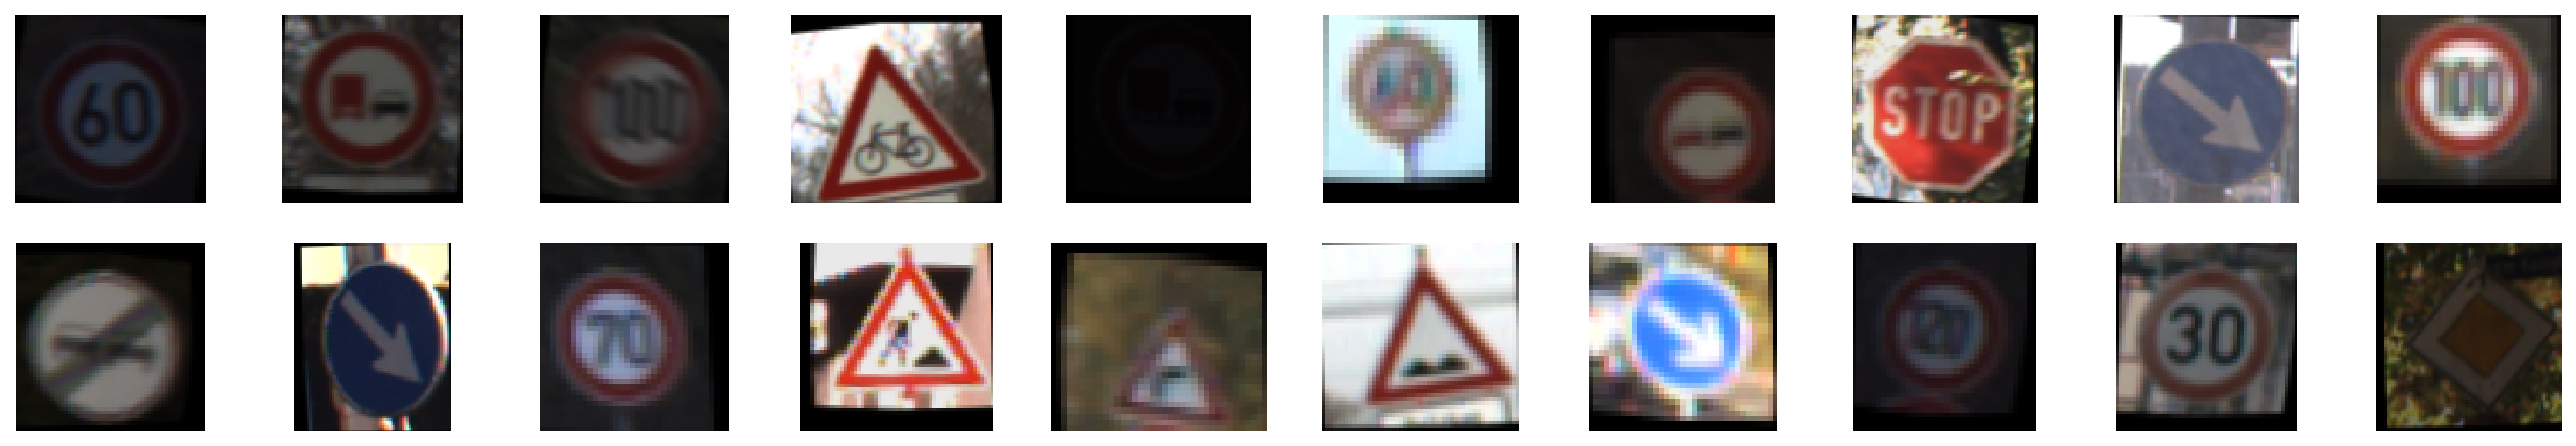

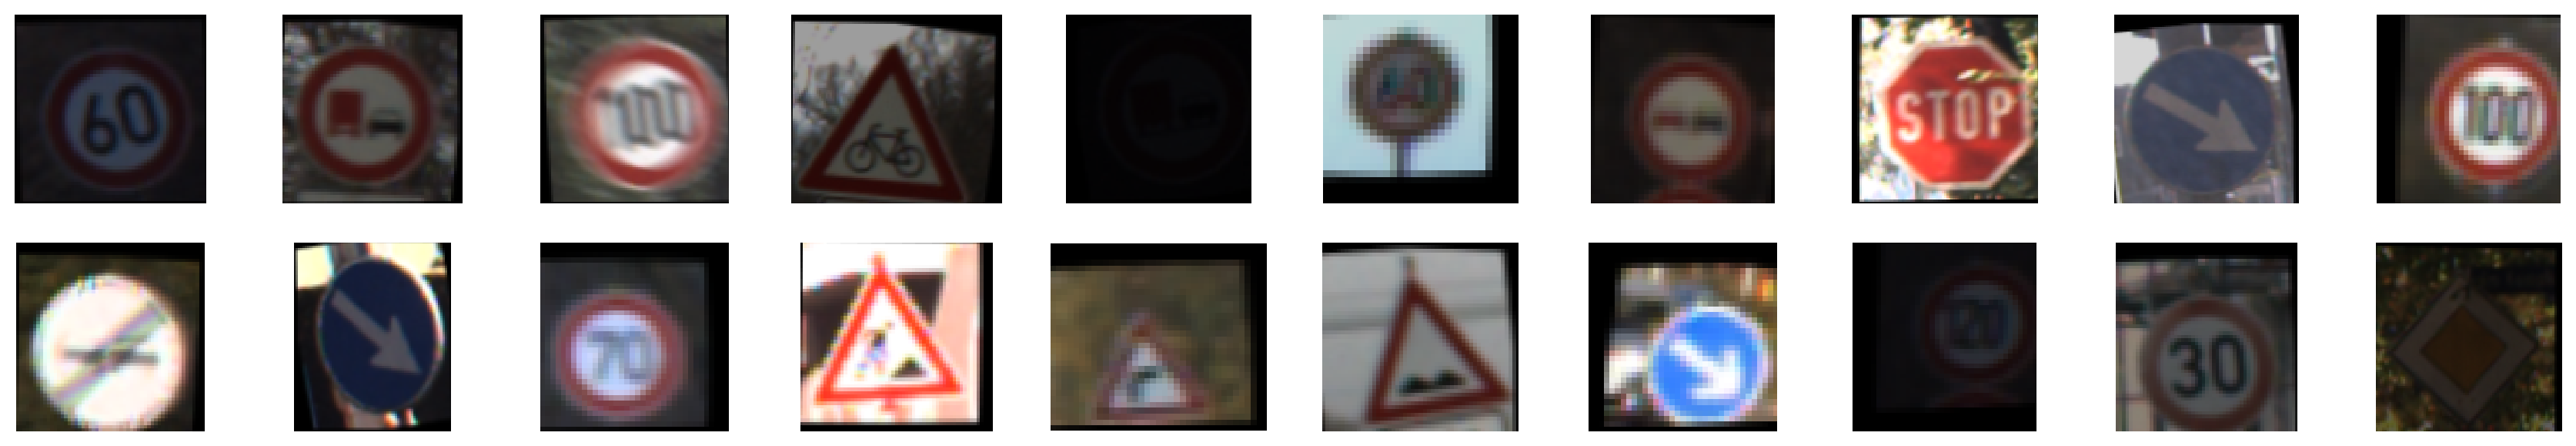

In [22]:

sample_data = get_samples(traindf,20)
show_images(sample_data[10:], cols=10) #original images
for _ in range(5):
    show_images(sample_data, cols=10, func=augmenter)
    

In [23]:
with Session() as session:
    functions = [loader, augmenter]
    pipeline = build_pipeline(functions, session, make_net(), make_adam(1.0e-3))
    train_eval(pipeline)

Epoch: 0 Train Score: 0.280 Evaluation Score: 0.280
Epoch: 1 Train Score: 0.482 Evaluation Score: 0.473
Epoch: 2 Train Score: 0.589 Evaluation Score: 0.582
Epoch: 3 Train Score: 0.635 Evaluation Score: 0.639
Epoch: 4 Train Score: 0.676 Evaluation Score: 0.680


**Conclusion**:

The hyper-parameters like brightness, rotation, translation, shear are tuned by looking at the randomly altered images.  If the alteration is too big, it is not so realistic.  The same way that horizontal flip is not included, a big change like rotating 90 degree should not be used.

The performance with the augmentation is much worse than without it.  There are two possible reasons:

1. the network is not robust to these changes (it was memorizing than generalizing)
2. it takes more time to train with larger data

Let's see how other preprocessing techniques can improve the performance first. Once that's done, we will use much bigger epochs to properly measure the performance.

## Data Normalization

In this section we will evaluate various normalization techniques to see which one has the best performance.

In [24]:
normalizers = [('x - 127.5', lambda x: x - 127.5),
               ('x/127.5 - 0.5', lambda x: x/127.5 - 1.0),
               ('x/255/0 - 0.5', lambda x: x/255.0 - 0.5),
               ('x - x.mean()', lambda x: x - x.mean()),
               ('(x - x.mean())/x.std()', lambda x: (x - x.mean())/x.std())]

for name, normalizer in normalizers:
    print('Normalizer: {}'.format(name))
    with Session() as session:
        functions = [loader, augmenter, normalizer]
        pipeline = build_pipeline(functions, session, make_net(), make_adam(1.0e-3))
        train_eval(pipeline)

Normalizer: x - 127.5
Epoch: 0 Train Score: 0.397 Evaluation Score: 0.396
Epoch: 1 Train Score: 0.558 Evaluation Score: 0.554
Epoch: 2 Train Score: 0.629 Evaluation Score: 0.621
Epoch: 3 Train Score: 0.664 Evaluation Score: 0.663
Epoch: 4 Train Score: 0.758 Evaluation Score: 0.754
Normalizer: x/127.5 - 0.5
Epoch: 0 Train Score: 0.558 Evaluation Score: 0.558
Epoch: 1 Train Score: 0.729 Evaluation Score: 0.722
Epoch: 2 Train Score: 0.783 Evaluation Score: 0.772
Epoch: 3 Train Score: 0.825 Evaluation Score: 0.826
Epoch: 4 Train Score: 0.830 Evaluation Score: 0.834
Normalizer: x/255/0 - 0.5
Epoch: 0 Train Score: 0.516 Evaluation Score: 0.506
Epoch: 1 Train Score: 0.646 Evaluation Score: 0.644
Epoch: 2 Train Score: 0.750 Evaluation Score: 0.744
Epoch: 3 Train Score: 0.786 Evaluation Score: 0.781
Epoch: 4 Train Score: 0.825 Evaluation Score: 0.821
Normalizer: x - x.mean()
Epoch: 0 Train Score: 0.464 Evaluation Score: 0.463
Epoch: 1 Train Score: 0.700 Evaluation Score: 0.699
Epoch: 2 Train Sc

**Conclusion**:

The performance with any of the normalizations is better than without them.  In this experiment, the normalization with `(x-x.mean())/x.std()` produced the best performance. 

In [25]:
normilizer = lambda x: (x - x.mean()) / x.std()

## Color Space

Now, let us try difference color space to see if there is any performance gain.

Note: Gray scale has only one channel so it needs to be handled separately.

**Color Code Reference**:

- http://docs.opencv.org/3.2.0/de/d25/imgproc_color_conversions.html
- https://en.wikipedia.org/wiki/CIE_1931_color_space

In [26]:
# for Gray scale, we need to add the 3rd dimension back (1 channel) as it's expected by the network
converters = [('Gray', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)[:, :, np.newaxis]),
              ('HSV', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2HSV)),
              ('HLS', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2HLS)),
              ('Lab', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2Lab)),
              ('Luv', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2Luv)),
              ('XYZ', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2XYZ)),
              ('Yrb', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2YCrCb)),
              ('YUV', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2YUV))]

GRAY_INPUT_SHAPE = (*INPUT_SHAPE[:2], 1)

for name, converter in converters:
    print('Color Space: {}'.format(name))
    with Session() as session:
        functions = [loader, augmenter, converter, normalizer]
        if name == 'Gray':
            network = make_net(input_shape=GRAY_INPUT_SHAPE) # there is only one channel in gray scale
        else:
            network = make_net()
        pipeline = build_pipeline(functions, session, network, make_adam(1.0e-3))
        train_eval(pipeline)
    print()

Color Space: Gray
Epoch: 0 Train Score: 0.669 Evaluation Score: 0.675
Epoch: 1 Train Score: 0.806 Evaluation Score: 0.801
Epoch: 2 Train Score: 0.843 Evaluation Score: 0.842
Epoch: 3 Train Score: 0.871 Evaluation Score: 0.868
Epoch: 4 Train Score: 0.890 Evaluation Score: 0.891

Color Space: HSV
Epoch: 0 Train Score: 0.529 Evaluation Score: 0.523
Epoch: 1 Train Score: 0.664 Evaluation Score: 0.652
Epoch: 2 Train Score: 0.723 Evaluation Score: 0.714
Epoch: 3 Train Score: 0.765 Evaluation Score: 0.754
Epoch: 4 Train Score: 0.800 Evaluation Score: 0.787

Color Space: HLS
Epoch: 0 Train Score: 0.455 Evaluation Score: 0.450
Epoch: 1 Train Score: 0.594 Evaluation Score: 0.592
Epoch: 2 Train Score: 0.697 Evaluation Score: 0.691
Epoch: 3 Train Score: 0.754 Evaluation Score: 0.749
Epoch: 4 Train Score: 0.787 Evaluation Score: 0.783

Color Space: Lab
Epoch: 0 Train Score: 0.551 Evaluation Score: 0.546
Epoch: 1 Train Score: 0.685 Evaluation Score: 0.683
Epoch: 2 Train Score: 0.755 Evaluation Score

**Conlcusion**:

RGB (no conversion) is the best. 
I was expecting the gray scale to be more efficient as the traffic signs are mostly about shapes not colors.  
The gray scale would have reduced the dimensionality from 3 color channels to 1, which would make the learning faster/easier. 
Apparently, that is not the case.  


For preprocessing, we choose the normalizer as it is more effecient

In [27]:
preprocessors = [loader, augmenter, lambda x: (x - x.mean())/x.std()]

# Model Improvement

Lets see if we can improve performance without overfitting by trying the following:

- add more layers in conv layers
- add more neurons in dense layers
- add more conv layers
- add more dense layers
- try different activation like elu instead of relu
- add dropout

In [28]:
#Lets use some helper functions for plotting
def show_learning_curve(learning_curve):
    """
        Plots learning curve
    """
    epochs, train, valid = learning_curve
    plt.figure(figsize=(10,10))
    plt.plot(epochs, train, label='train')
    plt.plot(epochs, valid, label='validation')
    plt.title('Learning curve')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.xticks(epochs)
    plt.legend(loc='center right')
    
def show_confusion_matrix(cm):
    """
        Plots the confusion matrix
    """
    cm = [row/sum(row) for row in cm]
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=plt.cm.Oranges)
    fig.colorbar(cax)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class IDs')
    plt.ylabel('True Class IDs')
    plt.show()
    
def print_confusion_matrix(cm, sign_names=SIGN_NAMES):
    """
        Prints the confusion matrix
    """ 
    results = [(i, SIGN_NAMES[i], row[i]/sum(row)*100) for i, row in enumerate(cm)]
    accuracies = []
    for result in sorted(results, key=lambda x: -x[2]):
        print('{:>2} {:<50} {:6.2f}% {:>4}'.format(*result, sum(y_train==result[0])))
        accuracies.append(result[2])
    print('-'*50)
    print('Accuracy: Mean: {:.3f} Std: {:.3f}'.format(np.mean(accuracies), np.std(accuracies)))
    

Now, let us double the convulutional layers and neurons in the dense layers

In [30]:
def make_net_double(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
           .input(input_shape)
           .conv([5,5,12]) #previous 5,5,6
           .max_pool().relu()
           .conv([5,5,32]) #previous 5,5,16
           .max_pool()
           .relu().flatten().dense(240).relu().dense(N_CLASSES) #previous 120
           )

Epoch: 0 Train Score: 0.821 Evaluation Score: 0.818
Epoch: 1 Train Score: 0.917 Evaluation Score: 0.911
Epoch: 2 Train Score: 0.934 Evaluation Score: 0.934
Epoch: 3 Train Score: 0.924 Evaluation Score: 0.917
Epoch: 4 Train Score: 0.955 Evaluation Score: 0.950


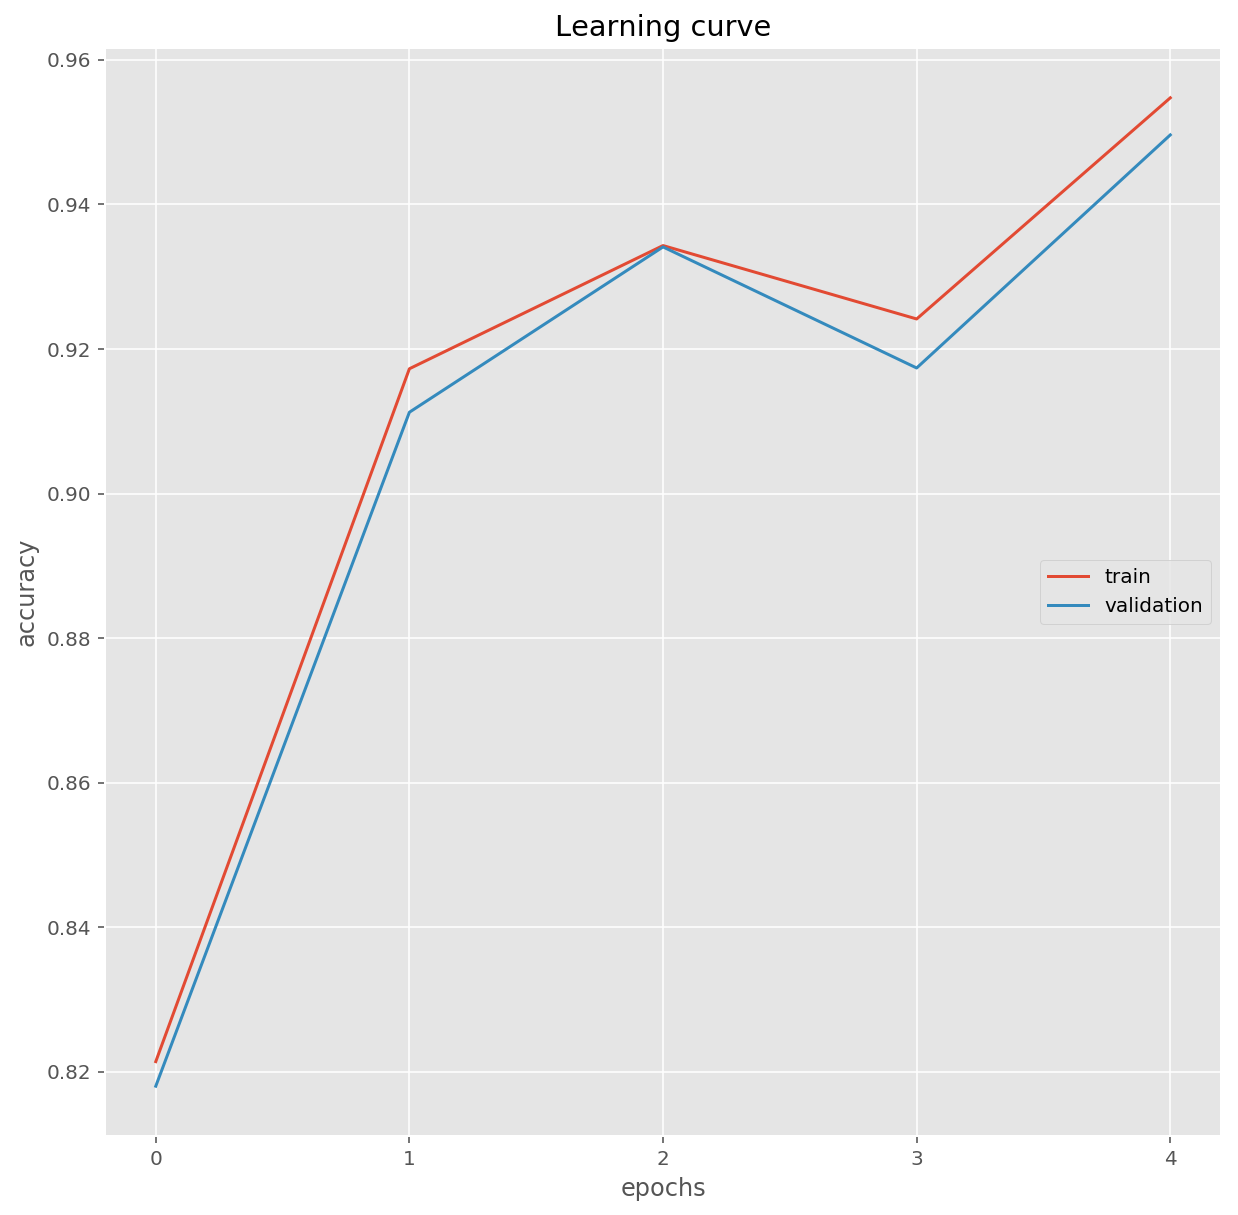

In [31]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double(), make_adam(1.0e-3))
    learning_curve = train_eval(pipeline)
    session.save('checkpoint/make_net_double.ckpt')
    
show_learning_curve(learning_curve)

INFO:tensorflow:Restoring parameters from checkpoint/make_net_double.ckpt


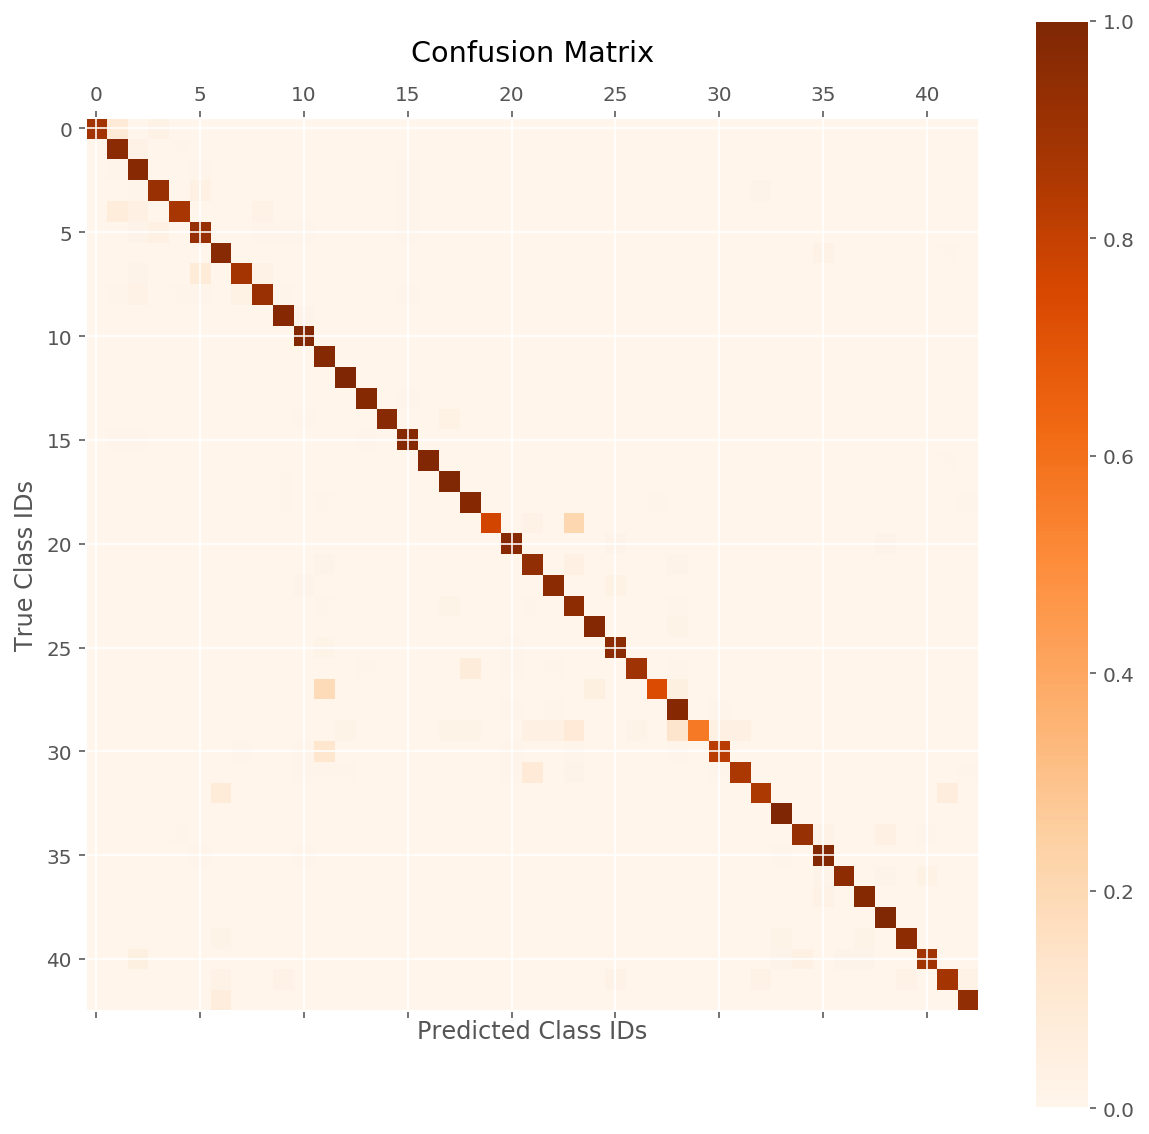

33 Turn right ahead                                   100.00%  548
12 Priority road                                       99.77% 1672
17 No entry                                            99.56%  884
38 Keep right                                          99.53% 1648
10 No passing for vehicles over 3.5 metric tons        99.27% 1600
16 Vehicles over 3.5 metric tons prohibited            98.84%  334
35 Ahead only                                          98.78%  955
24 Road narrows on the right                           98.18%  215
13 Yield                                               97.96% 1719
11 Right-of-way at the next intersection               97.77% 1051
15 No vehicles                                         97.67%  501
37 Go straight or left                                 97.67%  167
18 General caution                                     97.55%  955
 9 No passing                                          97.33% 1170
28 Children crossing                                   97.27% 

In [32]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double())
    session.load('checkpoint/make_net_double.ckpt')
    pred = pipeline.predict(X_valid)

cm = confusion_matrix(y_valid, pred)
show_confusion_matrix(cm)
print_confusion_matrix(cm)

**Conclusion**:

The performance improved. The training accuracy is slightly higher than the validation accuracy.  It might be a sign of overfitting but I'll need to see by increasing the complexity of the network.

Let us try to doubling all filters in the convulutional layers and neurons in the dense layers

In [33]:
def make_net_double2x(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
           .input(input_shape)
           .conv([5,5,24]) #previous 5,5,12
           .max_pool().relu()
           .conv([5,5,64]) #previous 5,5,32
           .max_pool()
           .relu().flatten().dense(480).relu().dense(N_CLASSES) #previous 240
           )

In [35]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x(), make_adam(1.0e-3))
    learning_curve = train_eval(pipeline)
    session.save('checkpoint/make_net_double2x.ckpt')
    


Epoch: 0 Train Score: 0.893 Evaluation Score: 0.888
Epoch: 1 Train Score: 0.947 Evaluation Score: 0.947
Epoch: 2 Train Score: 0.967 Evaluation Score: 0.965
Epoch: 3 Train Score: 0.958 Evaluation Score: 0.957
Epoch: 4 Train Score: 0.974 Evaluation Score: 0.971


In [ ]:
show_learning_curve(learning_curve)

INFO:tensorflow:Restoring parameters from checkpoint/make_net_double2x.ckpt


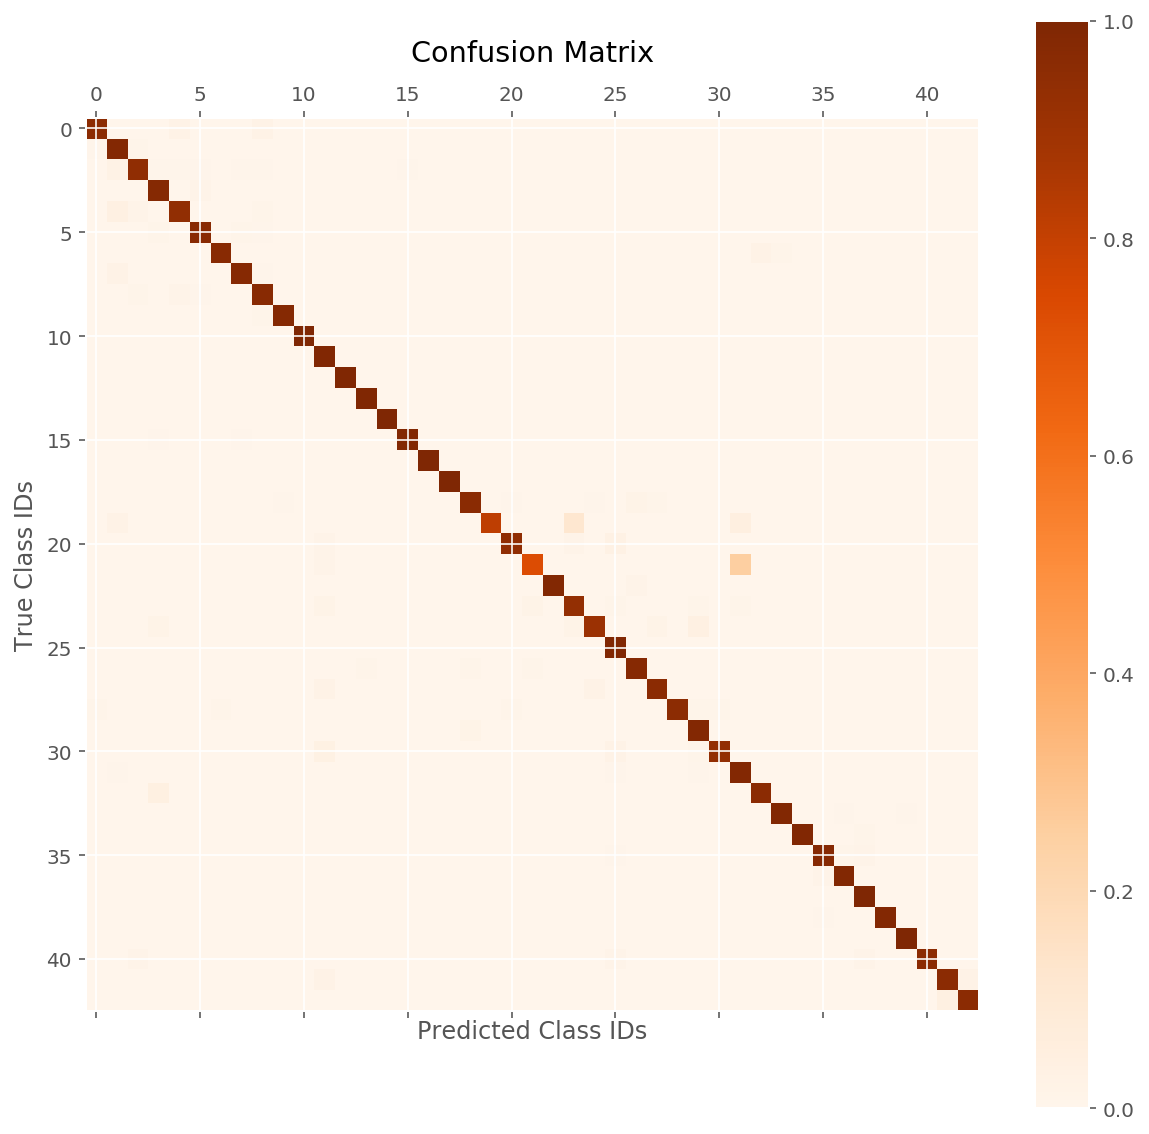

14 Stop                                               100.00%  621
16 Vehicles over 3.5 metric tons prohibited           100.00%  334
17 No entry                                           100.00%  884
37 Go straight or left                                100.00%  167
39 Keep left                                          100.00%  239
10 No passing for vehicles over 3.5 metric tons        99.76% 1600
12 Priority road                                       99.53% 1672
13 Yield                                               99.32% 1719
25 Road work                                           99.02% 1194
11 Right-of-way at the next intersection               98.88% 1051
34 Turn left ahead                                     98.84%  334
22 Bumpy road                                          98.75%  310
36 Go straight or right                                98.75%  310
33 Turn right ahead                                    98.58%  548
15 No vehicles                                         98.45% 

In [34]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x())
    session.load('checkpoint/make_net_double2x.ckpt')
    pred = pipeline.predict(X_valid)

cm = confusion_matrix(y_valid, pred)
show_confusion_matrix(cm)
print_confusion_matrix(cm)

**Conclusion**:

The performance is better.  It may be showing a slight overfitting.  Maybe it is not a good ideia to apply any regularization at this stage.  Let us rather try more epochs to see how far it can improve.

For almost all classes, the network is producing better than 90% accuracy, proving that increasing the network complexity is making it more robust.

Let us use make_net_double2x with more epochs

Epoch: 0 Train Score: 0.888 Evaluation Score: 0.887
Epoch: 1 Train Score: 0.939 Evaluation Score: 0.935
Epoch: 2 Train Score: 0.949 Evaluation Score: 0.947
Epoch: 3 Train Score: 0.967 Evaluation Score: 0.963
Epoch: 4 Train Score: 0.968 Evaluation Score: 0.963
Epoch: 5 Train Score: 0.967 Evaluation Score: 0.967
Epoch: 6 Train Score: 0.970 Evaluation Score: 0.967
Epoch: 7 Train Score: 0.970 Evaluation Score: 0.968
Epoch: 8 Train Score: 0.967 Evaluation Score: 0.966
Epoch: 9 Train Score: 0.981 Evaluation Score: 0.978
Epoch: 10 Train Score: 0.979 Evaluation Score: 0.977
Epoch: 11 Train Score: 0.981 Evaluation Score: 0.977
Epoch: 12 Train Score: 0.977 Evaluation Score: 0.971
Epoch: 13 Train Score: 0.977 Evaluation Score: 0.979
Epoch: 14 Train Score: 0.982 Evaluation Score: 0.979
Epoch: 15 Train Score: 0.980 Evaluation Score: 0.978
Epoch: 16 Train Score: 0.977 Evaluation Score: 0.974
Epoch: 17 Train Score: 0.979 Evaluation Score: 0.974
Epoch: 18 Train Score: 0.980 Evaluation Score: 0.978
Epo

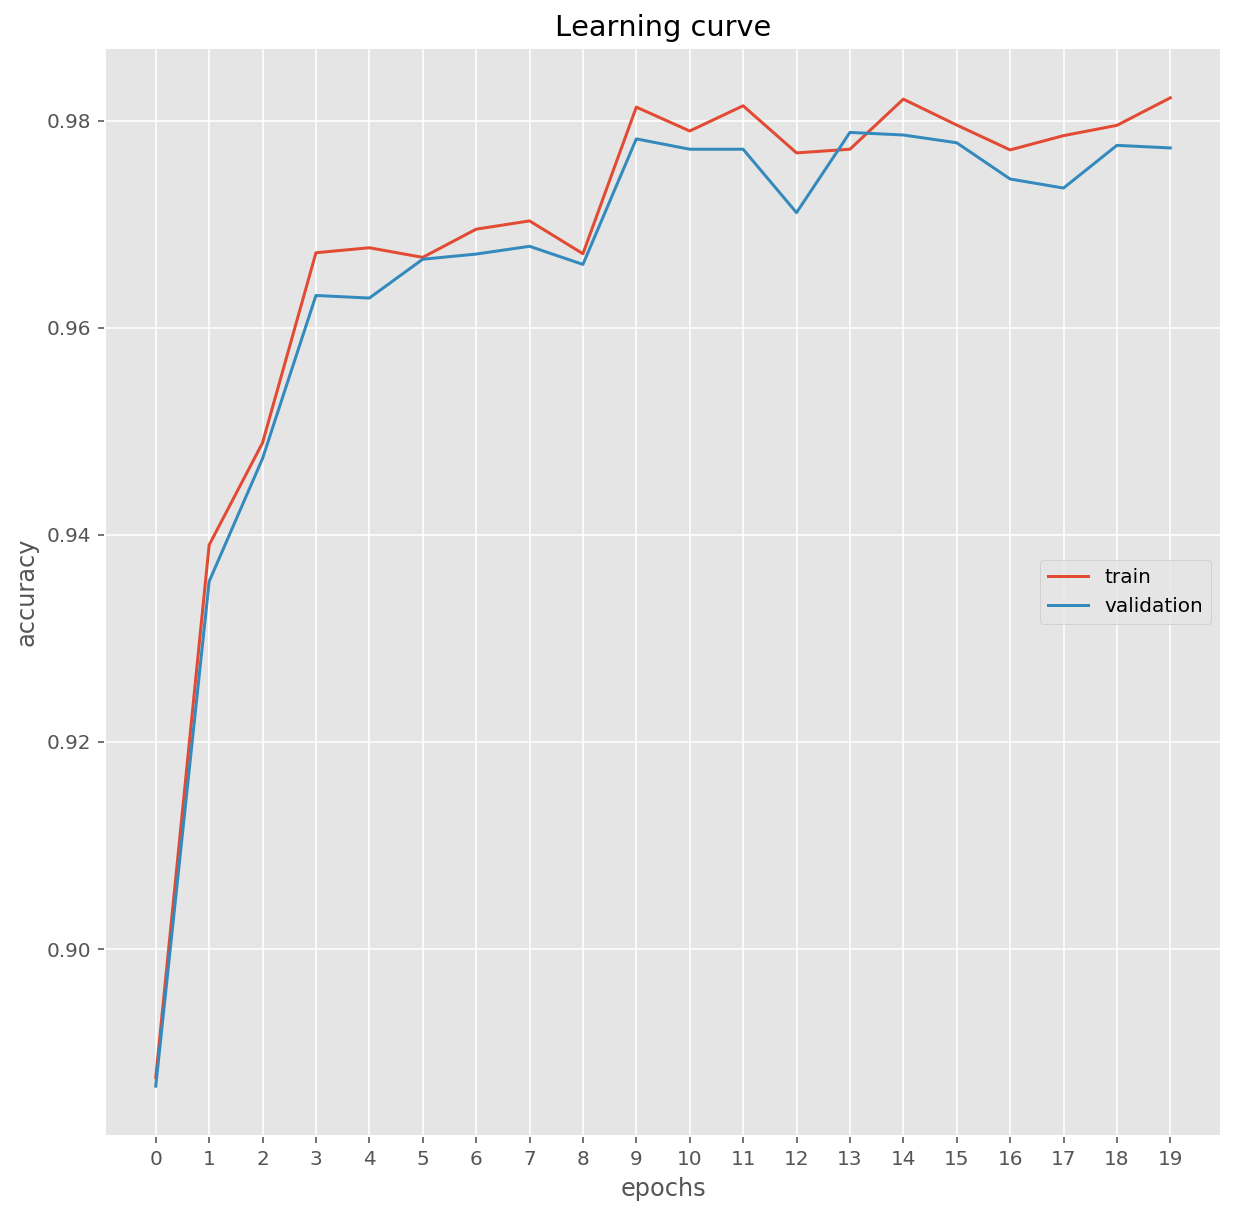

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x(), make_adam(1.0e-3))
    learning_curve = train_eval(pipeline, epochs=20)
    session.save('checkpoint/make_net_double2x-20.ckpt')
    
show_learning_curve(learning_curve)

INFO:tensorflow:Restoring parameters from checkpoint/make_net_double2x-20.ckpt


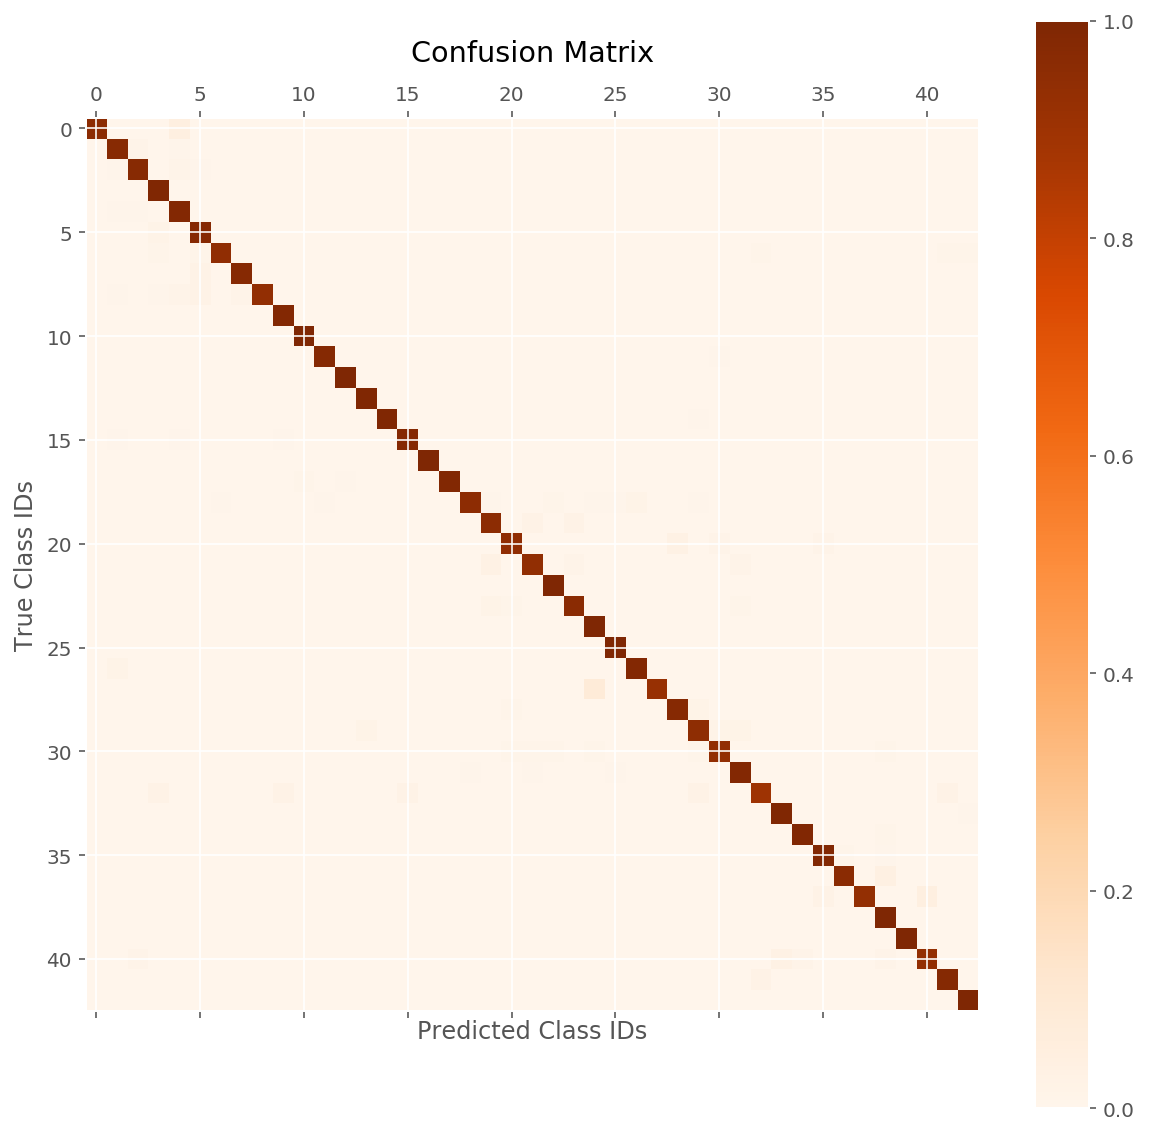

12 Priority road                                      100.00% 1672
16 Vehicles over 3.5 metric tons prohibited           100.00%  334
22 Bumpy road                                         100.00%  310
24 Road narrows on the right                          100.00%  215
39 Keep left                                          100.00%  239
42 End of no passing by vehicles over 3.5 metric tons 100.00%  191
38 Keep right                                          99.76% 1648
10 No passing for vehicles over 3.5 metric tons        99.76% 1600
25 Road work                                           99.67% 1194
13 Yield                                               99.55% 1719
14 Stop                                                99.37%  621
 3 Speed limit (60km/h)                                99.31% 1122
33 Turn right ahead                                    99.29%  548
34 Turn left ahead                                     98.84%  334
35 Ahead only                                          98.78% 

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x())
    session.load('checkpoint/make_net_double2x-20.ckpt')
    pred = pipeline.predict(X_valid)

cm = confusion_matrix(y_valid, pred)
show_confusion_matrix(cm)
print_confusion_matrix(cm)

**Conclusion**:

The performance did improve but not in the last several epochs.  

100% accuracy is achieved for more classes.  Also, the bottom performer is improving as well.

Let's try a lower learning rate with epochs=20.

Epoch: 0 Train Score: 0.825 Evaluation Score: 0.818
Epoch: 1 Train Score: 0.921 Evaluation Score: 0.911
Epoch: 2 Train Score: 0.955 Evaluation Score: 0.948
Epoch: 3 Train Score: 0.953 Evaluation Score: 0.951
Epoch: 4 Train Score: 0.970 Evaluation Score: 0.968
Epoch: 5 Train Score: 0.977 Evaluation Score: 0.970
Epoch: 6 Train Score: 0.982 Evaluation Score: 0.978
Epoch: 7 Train Score: 0.984 Evaluation Score: 0.981
Epoch: 8 Train Score: 0.981 Evaluation Score: 0.978
Epoch: 9 Train Score: 0.983 Evaluation Score: 0.982
Epoch: 10 Train Score: 0.985 Evaluation Score: 0.982
Epoch: 11 Train Score: 0.983 Evaluation Score: 0.979
Epoch: 12 Train Score: 0.985 Evaluation Score: 0.982
Epoch: 13 Train Score: 0.987 Evaluation Score: 0.984
Epoch: 14 Train Score: 0.984 Evaluation Score: 0.981
Epoch: 15 Train Score: 0.992 Evaluation Score: 0.988
Epoch: 16 Train Score: 0.986 Evaluation Score: 0.983
Epoch: 17 Train Score: 0.992 Evaluation Score: 0.987
Epoch: 18 Train Score: 0.987 Evaluation Score: 0.982
Epo

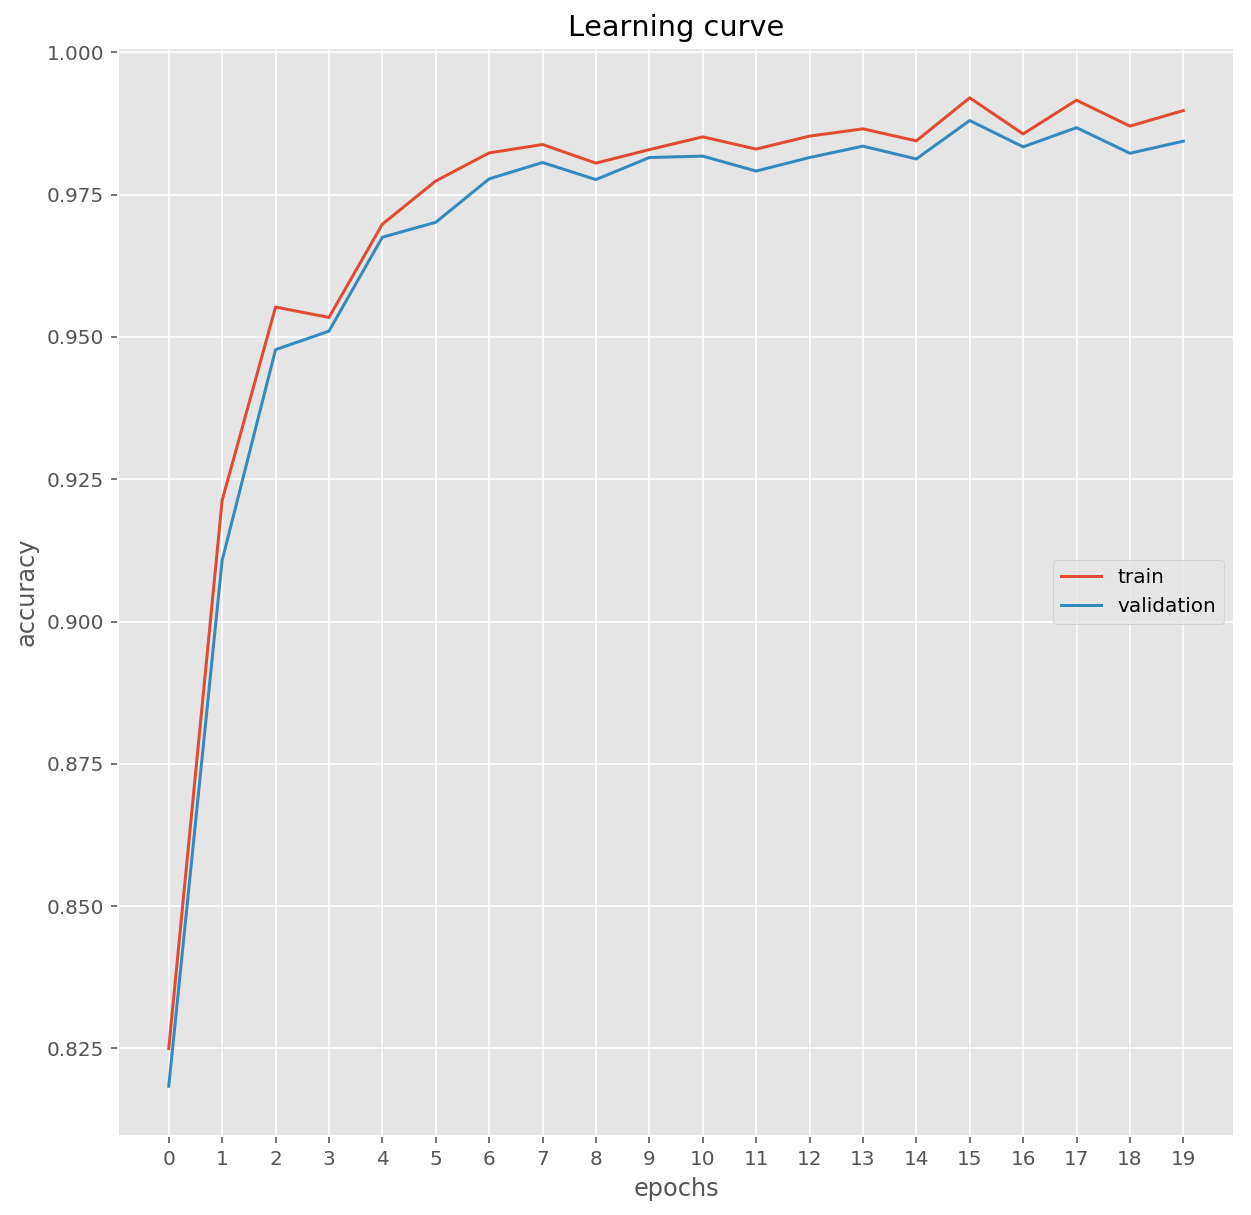

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x(), make_adam(0.5e-3))
    learning_curve = train_eval(pipeline, epochs=20)
    session.save('checkpoint/make_net_double2x-20_lr_0.5e-3.ckpt')
    
show_learning_curve(learning_curve)

INFO:tensorflow:Restoring parameters from checkpoint/make_net_double2x-20_lr_0.5e-3.ckpt


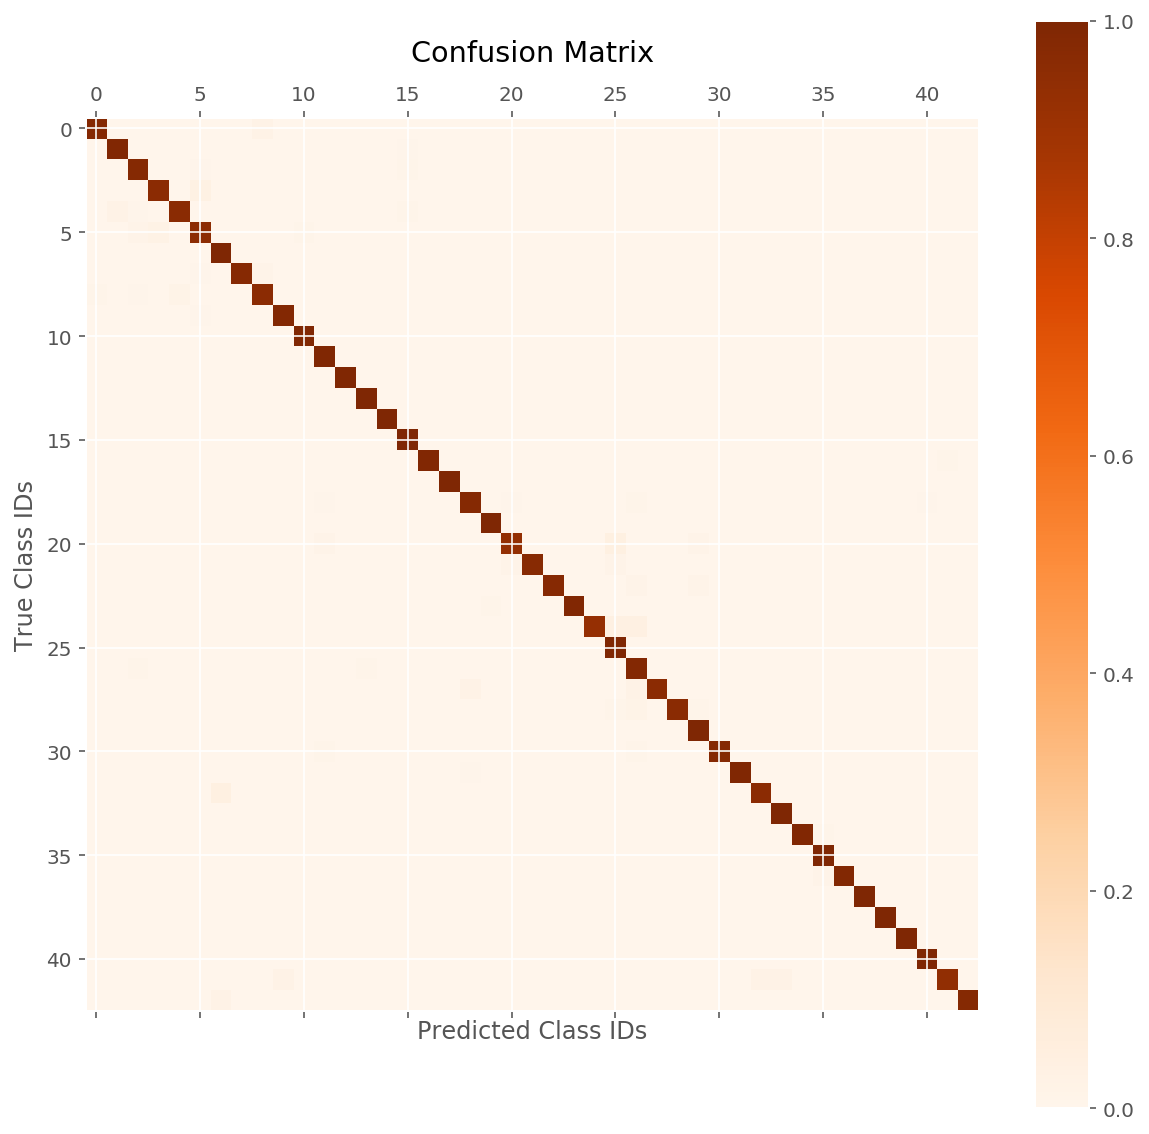

 6 End of speed limit (80km/h)                        100.00%  334
13 Yield                                              100.00% 1719
14 Stop                                               100.00%  621
15 No vehicles                                        100.00%  501
17 No entry                                           100.00%  884
19 Dangerous curve to the left                        100.00%  167
25 Road work                                          100.00% 1194
29 Bicycles crossing                                  100.00%  215
33 Turn right ahead                                   100.00%  548
35 Ahead only                                         100.00%  955
37 Go straight or left                                100.00%  167
39 Keep left                                          100.00%  239
40 Roundabout mandatory                               100.00%  287
38 Keep right                                          99.76% 1648
12 Priority road                                       99.53% 

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x())
    session.load('checkpoint/make_net_double2x-20_lr_0.5e-3.ckpt')
    pred = pipeline.predict(X_valid)

cm = confusion_matrix(y_valid, pred)
show_confusion_matrix(cm)
print_confusion_matrix(cm)

**Conclusion**:

The performance is almost the same  or slightly better.  
The learning curve looks much smoother.  
The average accuracy per class is slightly better too.  
Overall, smaller learning rate was a worthy change.

Decrease learning rate of make_net_double2x 

Epoch: 0 Train Score: 0.562 Evaluation Score: 0.566
Epoch: 1 Train Score: 0.721 Evaluation Score: 0.711
Epoch: 2 Train Score: 0.791 Evaluation Score: 0.779
Epoch: 3 Train Score: 0.850 Evaluation Score: 0.843
Epoch: 4 Train Score: 0.874 Evaluation Score: 0.868
Epoch: 5 Train Score: 0.890 Evaluation Score: 0.882
Epoch: 6 Train Score: 0.920 Evaluation Score: 0.915
Epoch: 7 Train Score: 0.929 Evaluation Score: 0.922
Epoch: 8 Train Score: 0.938 Evaluation Score: 0.937
Epoch: 9 Train Score: 0.944 Evaluation Score: 0.938
Epoch: 10 Train Score: 0.952 Evaluation Score: 0.949
Epoch: 11 Train Score: 0.958 Evaluation Score: 0.951
Epoch: 12 Train Score: 0.964 Evaluation Score: 0.954
Epoch: 13 Train Score: 0.969 Evaluation Score: 0.963
Epoch: 14 Train Score: 0.970 Evaluation Score: 0.962
Epoch: 15 Train Score: 0.975 Evaluation Score: 0.968
Epoch: 16 Train Score: 0.977 Evaluation Score: 0.972
Epoch: 17 Train Score: 0.979 Evaluation Score: 0.974
Epoch: 18 Train Score: 0.979 Evaluation Score: 0.973
Epo

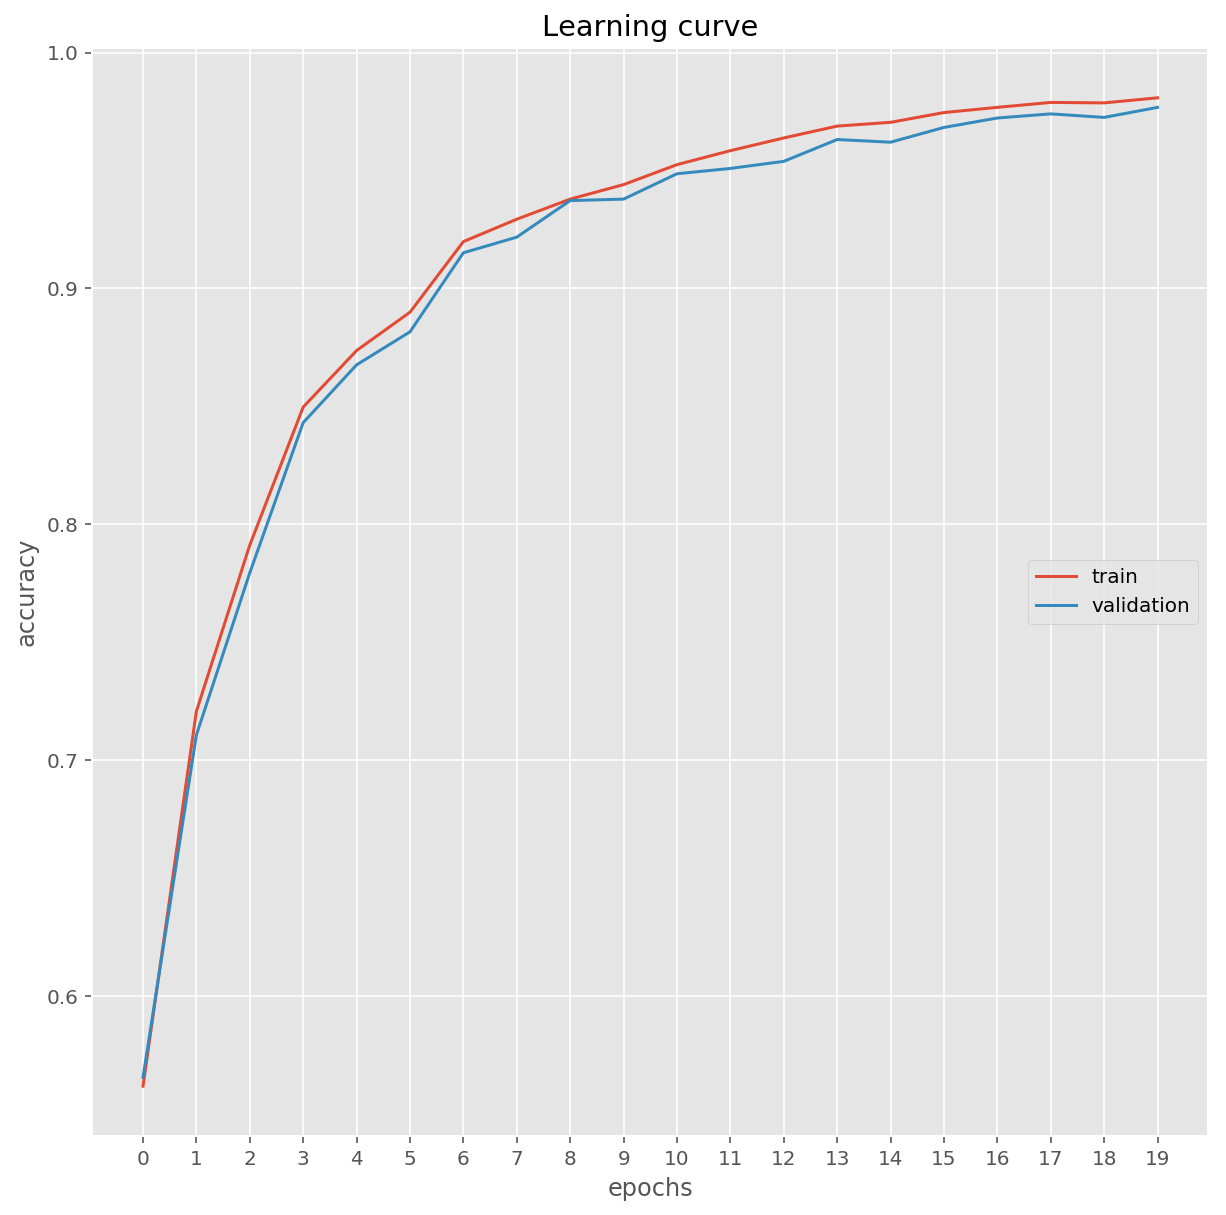

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x(), make_adam(1.0e-4))
    learning_curve = train_eval(pipeline, epochs=20)
    session.save('checkpoint/make_net_double2x-20_lr_1.0e-4.ckpt')
    
show_learning_curve(learning_curve)

INFO:tensorflow:Restoring parameters from checkpoint/make_net_double2x-20_lr_1.0e-4.ckpt


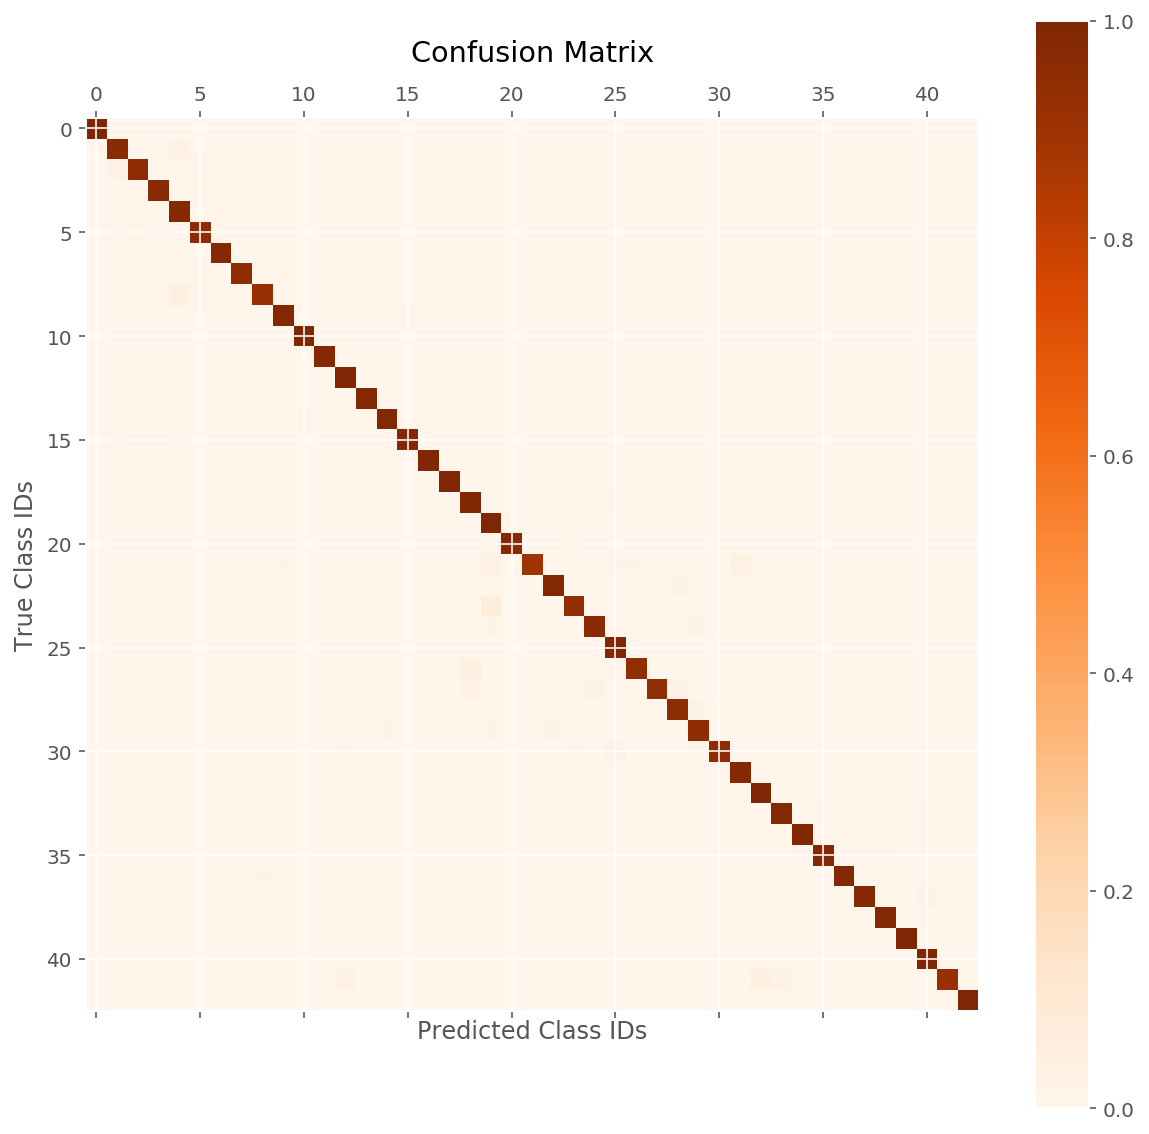

 0 Speed limit (20km/h)                               100.00%  167
17 No entry                                           100.00%  884
19 Dangerous curve to the left                        100.00%  167
32 End of all speed and passing limits                100.00%  191
39 Keep left                                          100.00%  239
40 Roundabout mandatory                               100.00%  287
42 End of no passing by vehicles over 3.5 metric tons 100.00%  191
12 Priority road                                       99.77% 1672
10 No passing for vehicles over 3.5 metric tons        99.51% 1600
25 Road work                                           99.35% 1194
18 General caution                                     99.18%  955
16 Vehicles over 3.5 metric tons prohibited            98.84%  334
34 Turn left ahead                                     98.84%  334
22 Bumpy road                                          98.75%  310
36 Go straight or right                                98.75% 

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x())
    session.load('checkpoint/make_net_double2x-20_lr_1.0e-4.ckpt')
    pred = pipeline.predict(X_valid)

cm = confusion_matrix(y_valid, pred)
show_confusion_matrix(cm)
print_confusion_matrix(cm)

**Conclusion**:

- The performance is worse and it seems to show some overfitting in the end.  
- The learning curve is much more smoother.
- The mean accuracy per class is worse and its standard devaition is bigger.

Let's stick with the previous learning rate for the time being.

Now let's try a leaky ReLU.

Epoch: 0 Train Score: 0.838 Evaluation Score: 0.828
Epoch: 1 Train Score: 0.916 Evaluation Score: 0.913
Epoch: 2 Train Score: 0.952 Evaluation Score: 0.952
Epoch: 3 Train Score: 0.957 Evaluation Score: 0.955
Epoch: 4 Train Score: 0.975 Evaluation Score: 0.966
Epoch: 5 Train Score: 0.975 Evaluation Score: 0.975
Epoch: 6 Train Score: 0.974 Evaluation Score: 0.972
Epoch: 7 Train Score: 0.978 Evaluation Score: 0.976
Epoch: 8 Train Score: 0.982 Evaluation Score: 0.978
Epoch: 9 Train Score: 0.984 Evaluation Score: 0.979
Epoch: 10 Train Score: 0.985 Evaluation Score: 0.981
Epoch: 11 Train Score: 0.986 Evaluation Score: 0.984
Epoch: 12 Train Score: 0.987 Evaluation Score: 0.987
Epoch: 13 Train Score: 0.984 Evaluation Score: 0.979
Epoch: 14 Train Score: 0.989 Evaluation Score: 0.985
Epoch: 15 Train Score: 0.988 Evaluation Score: 0.985
Epoch: 16 Train Score: 0.988 Evaluation Score: 0.986
Epoch: 17 Train Score: 0.989 Evaluation Score: 0.988
Epoch: 18 Train Score: 0.989 Evaluation Score: 0.988
Epo

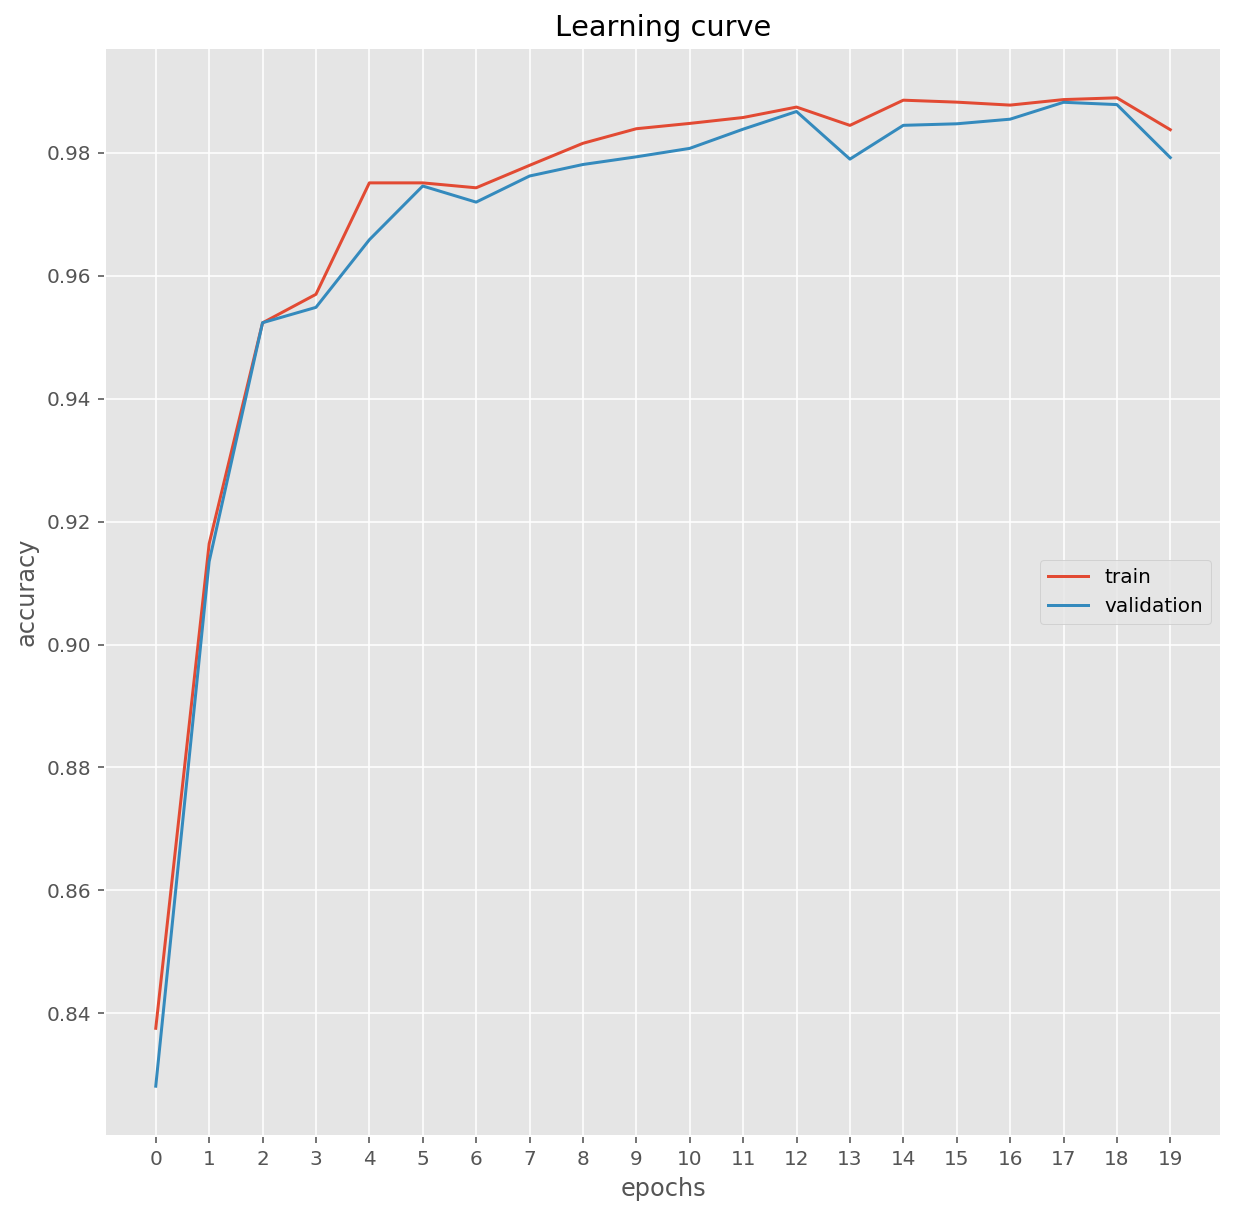

In [ ]:
def make_net_double2x_leakyrelu(input_shape=INPUT_SHAPE):
    """
    leak_ratio=0.01 Leaky ReLU
    """
    return (NeuralNetwork()
           .input(input_shape)
           .conv([5,5,24]) 
           .max_pool().relu(leak_ratio=0.01)
           .conv([5,5,64]) 
           .max_pool()
           .relu(leak_ratio=0.01).flatten().dense(480)
           .relu(leak_ratio=0.01).dense(N_CLASSES) 
           )


with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x_leakyrelu(), make_adam(0.5e-3))
    learning_curve = train_eval(pipeline, epochs=20)
    session.save('checkpoint/make_net_double2x-20_lr_0.5e-3.ckpt')
    
show_learning_curve(learning_curve)

INFO:tensorflow:Restoring parameters from checkpoint/make_net_double2x-20_lr_0.5e-3.ckpt


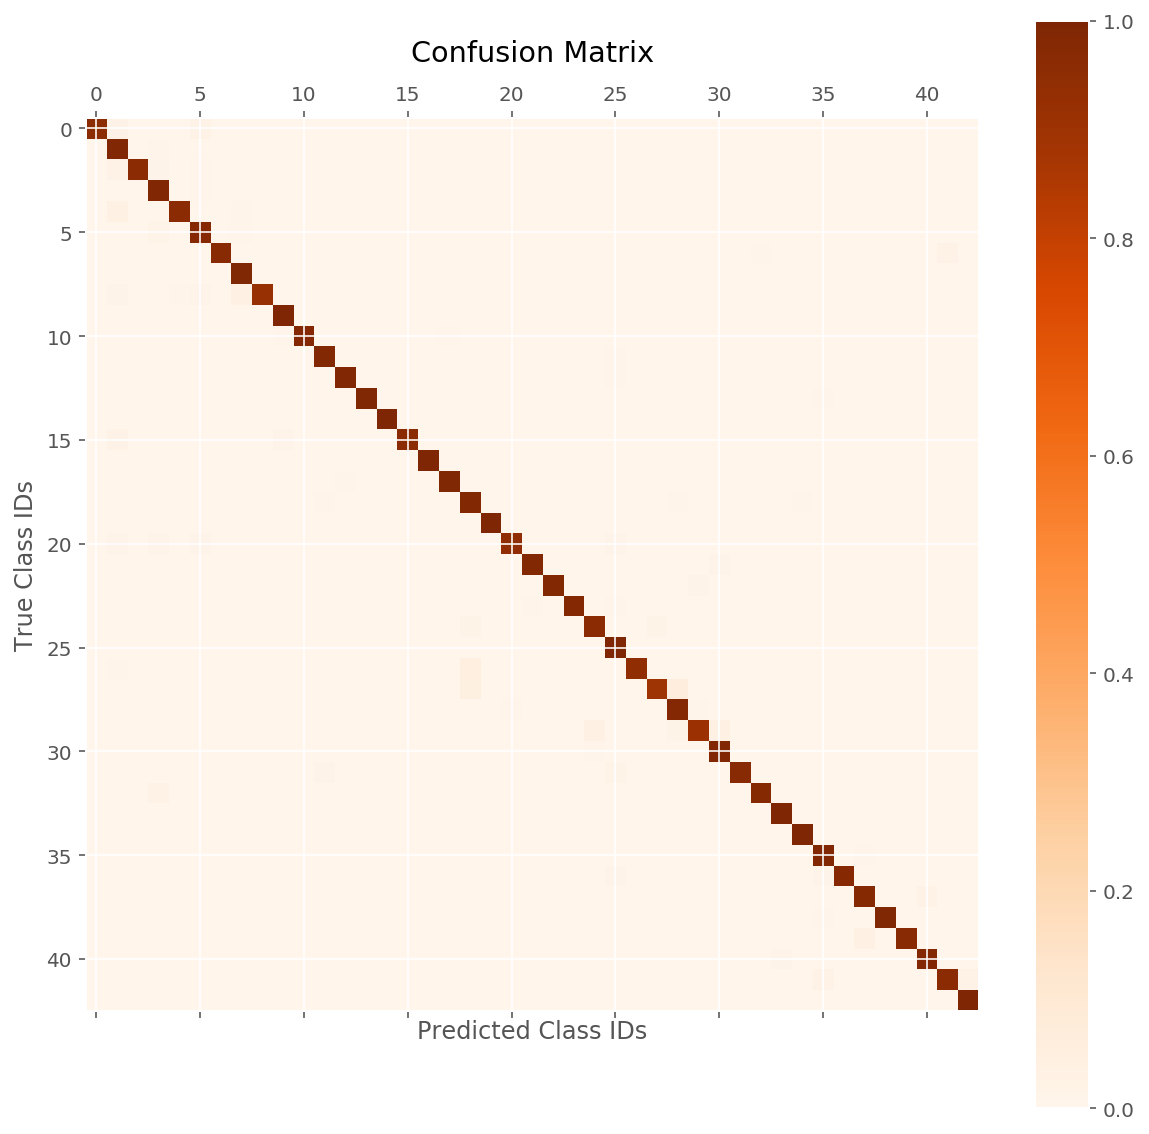

14 Stop                                               100.00%  621
16 Vehicles over 3.5 metric tons prohibited           100.00%  334
19 Dangerous curve to the left                        100.00%  167
33 Turn right ahead                                   100.00%  548
34 Turn left ahead                                    100.00%  334
42 End of no passing by vehicles over 3.5 metric tons 100.00%  191
25 Road work                                           99.67% 1194
 9 No passing                                          99.67% 1170
17 No entry                                            99.56%  884
13 Yield                                               99.55% 1719
 7 Speed limit (100km/h)                               99.32% 1146
38 Keep right                                          99.29% 1648
35 Ahead only                                          99.18%  955
12 Priority road                                       99.07% 1672
 3 Speed limit (60km/h)                                98.96% 

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x_leakyrelu())
    session.load('checkpoint/make_net_double2x-20_lr_0.5e-3.ckpt')
    pred = pipeline.predict(X_valid)

cm = confusion_matrix(y_valid, pred)
show_confusion_matrix(cm)
print_confusion_matrix(cm)

**Conclusion**:

No improvment.

It is time to try ELU (Exponential Linear Unit) activation which is supposed to be faster to learn than ReLU.

Reference: http://www.picalike.com/blog/2015/11/28/relu-was-yesterday-tomorrow-comes-elu/

Epoch: 0 Train Score: 0.814 Evaluation Score: 0.812
Epoch: 1 Train Score: 0.890 Evaluation Score: 0.881
Epoch: 2 Train Score: 0.903 Evaluation Score: 0.894
Epoch: 3 Train Score: 0.922 Evaluation Score: 0.920
Epoch: 4 Train Score: 0.931 Evaluation Score: 0.925


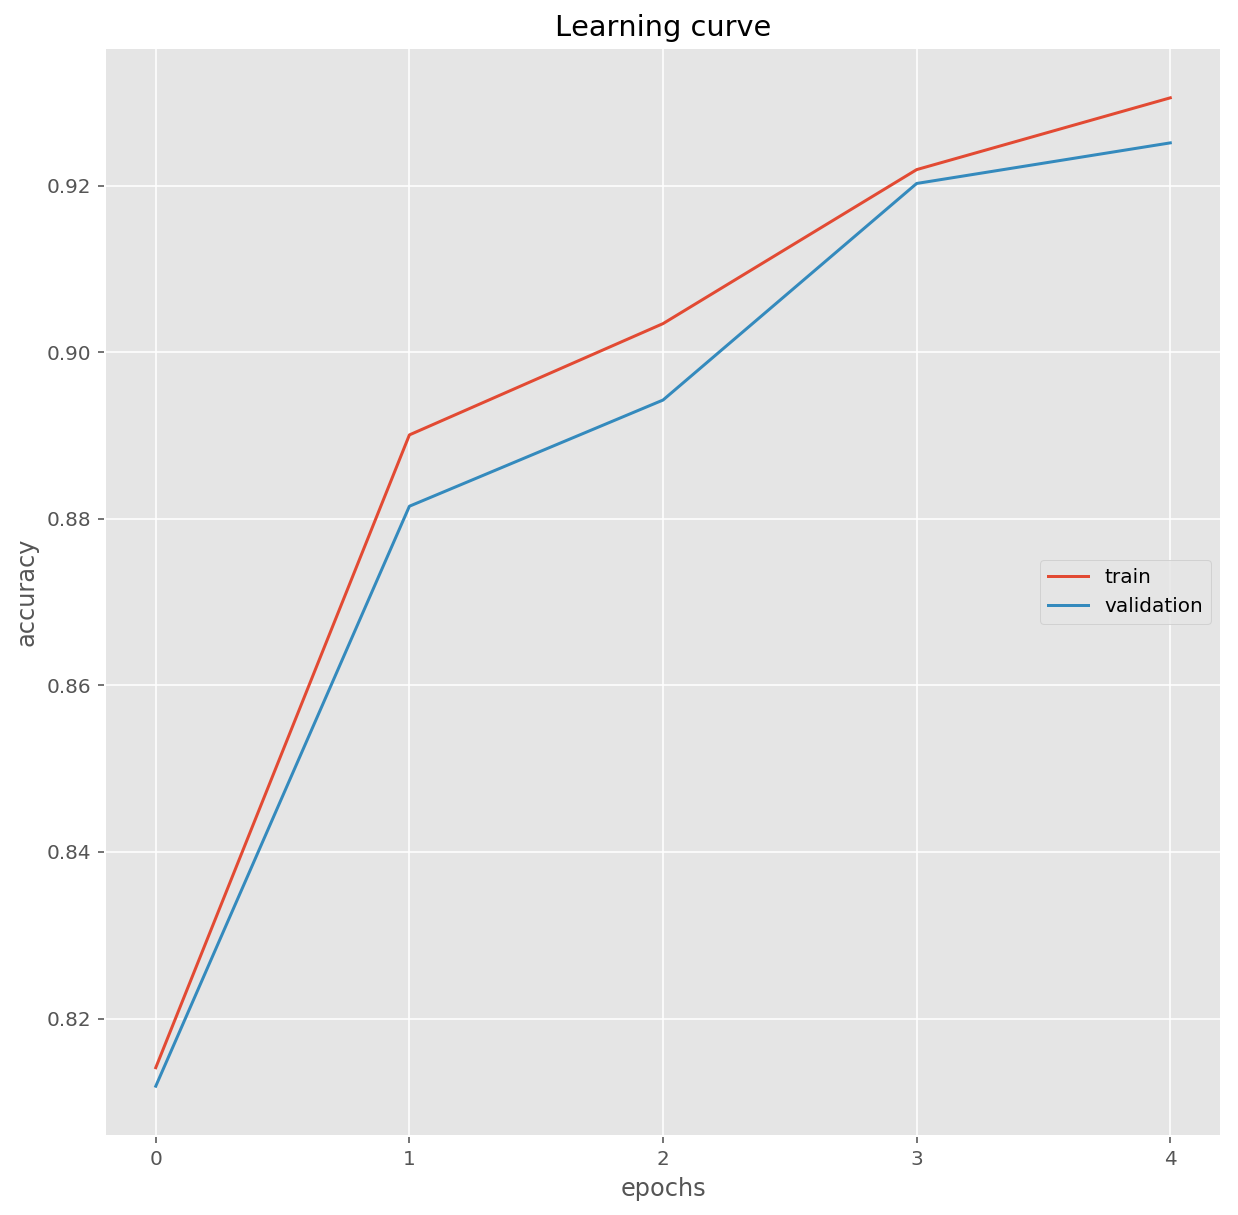

In [ ]:
def make_net_double2x_elu(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
           .input(input_shape)
           .conv([5,5,24]) 
           .max_pool().elu()
           .conv([5,5,64]) 
           .max_pool()
           .elu().flatten().dense(480).elu().dense(N_CLASSES) 
           )

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x_elu(), make_adam(1.0e-3))
    learning_curve = train_eval(pipeline)
    session.save('checkpoint/make_net_double2x_elu.ckpt')
    
show_learning_curve(learning_curve)

INFO:tensorflow:Restoring parameters from checkpoint/make_net_double2x_elu.ckpt


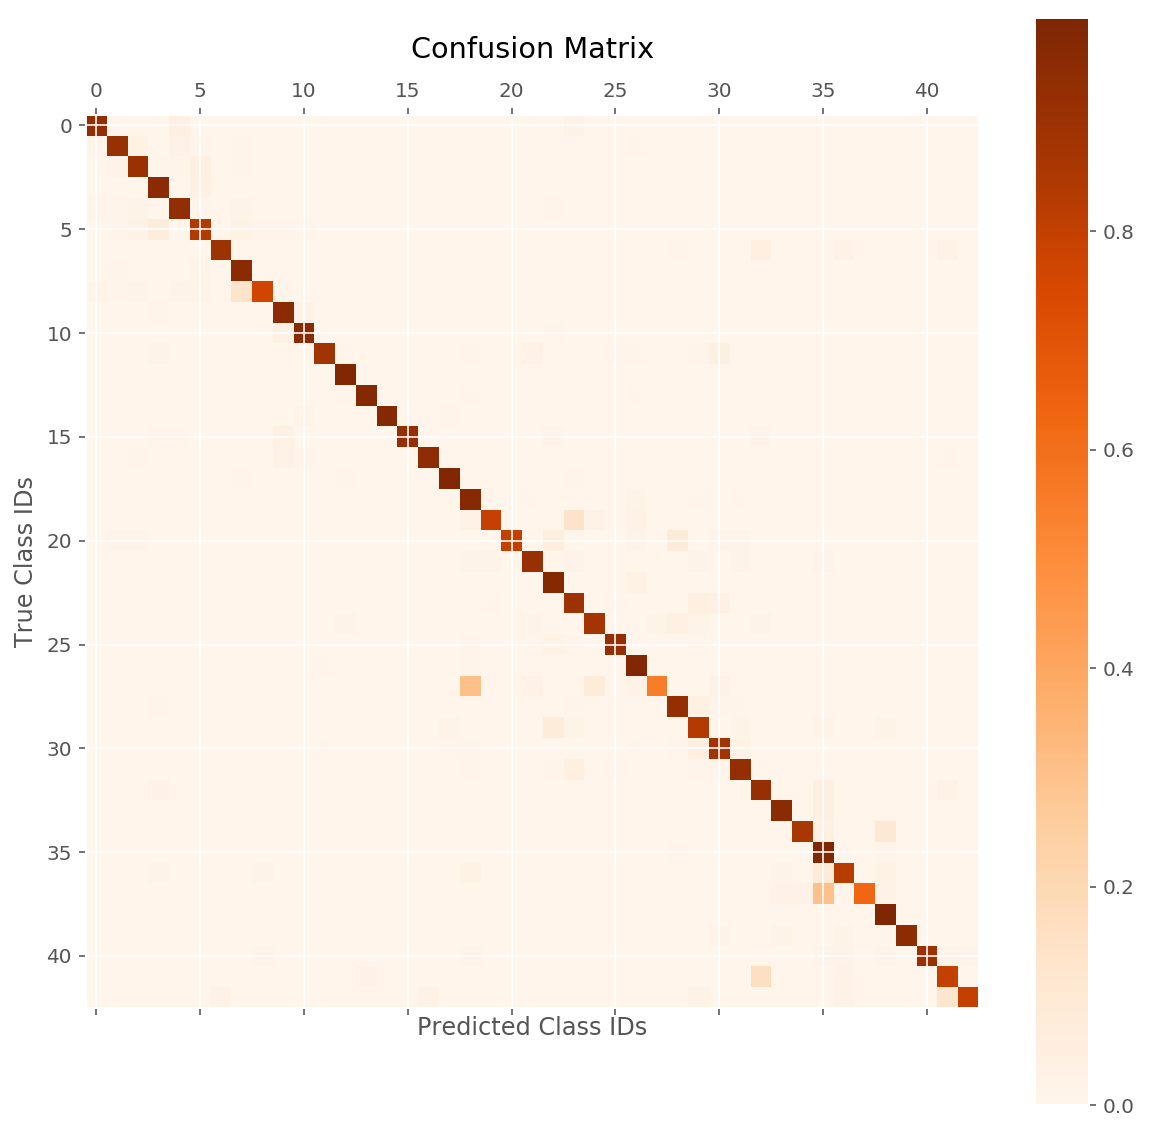

38 Keep right                                          99.53% 1648
35 Ahead only                                          98.78%  955
17 No entry                                            98.67%  884
12 Priority road                                       98.60% 1672
26 Traffic signals                                     98.36%  478
22 Bumpy road                                          97.50%  310
14 Stop                                                97.48%  621
13 Yield                                               97.28% 1719
18 General caution                                     96.73%  955
10 No passing for vehicles over 3.5 metric tons        96.10% 1600
33 Turn right ahead                                    95.74%  548
 9 No passing                                          95.67% 1170
 7 Speed limit (100km/h)                               95.58% 1146
 3 Speed limit (60km/h)                                95.49% 1122
39 Keep left                                           95.08% 

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x_elu())
    session.load('checkpoint/make_net_double2x_elu.ckpt')
    pred = pipeline.predict(X_valid)

cm = confusion_matrix(y_valid, pred)
show_confusion_matrix(cm)
print_confusion_matrix(cm)

**Conclusion**:

The permance is worse.  Also, it did not learn faster.

Now let's try to set lower initial weight value

Epoch: 0 Train Score: 0.885 Evaluation Score: 0.876
Epoch: 1 Train Score: 0.935 Evaluation Score: 0.929
Epoch: 2 Train Score: 0.960 Evaluation Score: 0.957
Epoch: 3 Train Score: 0.958 Evaluation Score: 0.959
Epoch: 4 Train Score: 0.971 Evaluation Score: 0.968


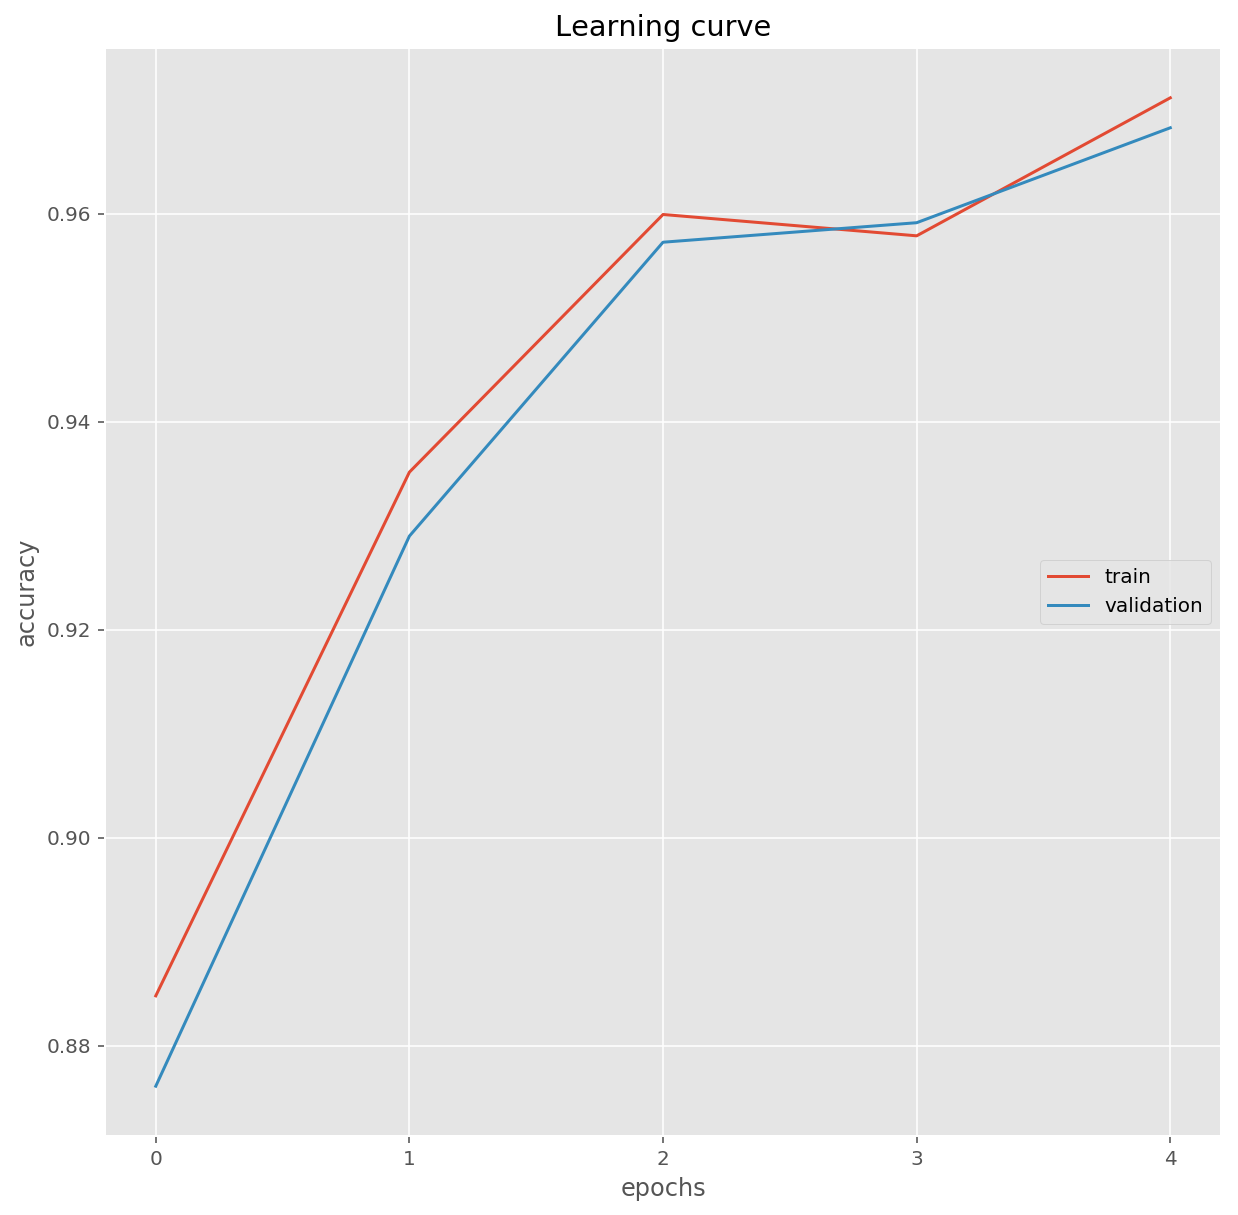

In [ ]:
def make_net_double2x_W(input_shape=INPUT_SHAPE):
    return (NeuralNetwork(weight_sigma=0.01) #smaller weight
           .input(input_shape)
           .conv([5,5,24]) 
           .max_pool().relu()
           .conv([5,5,64]) 
           .max_pool()
           .relu().flatten().dense(480).relu().dense(N_CLASSES) 
           )

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x_W(), make_adam(1.0e-3))
    learning_curve = train_eval(pipeline)
    session.save('checkpoint/make_net_double2x_W.ckpt')
    
show_learning_curve(learning_curve)

INFO:tensorflow:Restoring parameters from checkpoint/make_net_double2x_W.ckpt


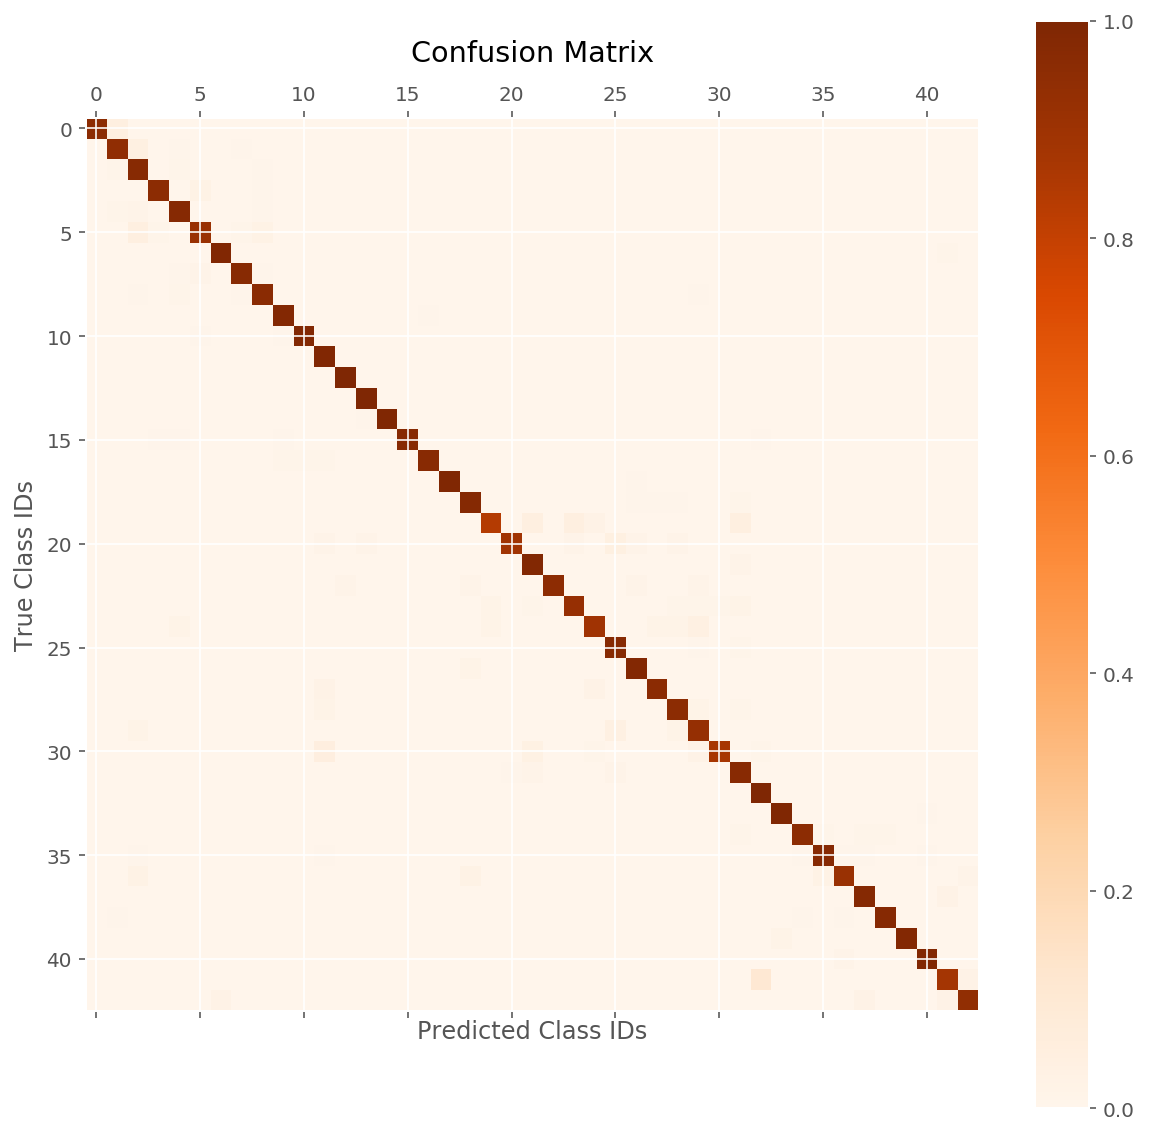

32 End of all speed and passing limits                100.00%  191
13 Yield                                               99.77% 1719
12 Priority road                                       99.77% 1672
17 No entry                                            99.56%  884
14 Stop                                                99.37%  621
33 Turn right ahead                                    99.29%  548
11 Right-of-way at the next intersection               98.88% 1051
 6 End of speed limit (80km/h)                         98.84%  334
10 No passing for vehicles over 3.5 metric tons        98.78% 1600
40 Roundabout mandatory                                98.63%  287
21 Double curve                                        98.51%  263
26 Traffic signals                                     98.36%  478
39 Keep left                                           98.36%  239
 9 No passing                                          98.33% 1170
18 General caution                                     97.96% 

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x_W())
    session.load('checkpoint/make_net_double2x_W.ckpt')
    pred = pipeline.predict(X_valid)

cm = confusion_matrix(y_valid, pred)
show_confusion_matrix(cm)
print_confusion_matrix(cm)

**Conclusion**:

No improvement - a bit worse.

Poof, Let's try more epochs with a smaller learning rate.

Epoch: 0 Train Score: 0.577 Evaluation Score: 0.574
Epoch: 1 Train Score: 0.728 Evaluation Score: 0.724
Epoch: 2 Train Score: 0.809 Evaluation Score: 0.799
Epoch: 3 Train Score: 0.859 Evaluation Score: 0.859
Epoch: 4 Train Score: 0.886 Evaluation Score: 0.881
Epoch: 5 Train Score: 0.910 Evaluation Score: 0.906
Epoch: 6 Train Score: 0.926 Evaluation Score: 0.917
Epoch: 7 Train Score: 0.933 Evaluation Score: 0.927
Epoch: 8 Train Score: 0.946 Evaluation Score: 0.937
Epoch: 9 Train Score: 0.953 Evaluation Score: 0.942
Epoch: 10 Train Score: 0.956 Evaluation Score: 0.953
Epoch: 11 Train Score: 0.962 Evaluation Score: 0.957
Epoch: 12 Train Score: 0.965 Evaluation Score: 0.959
Epoch: 13 Train Score: 0.970 Evaluation Score: 0.962
Epoch: 14 Train Score: 0.972 Evaluation Score: 0.966
Epoch: 15 Train Score: 0.974 Evaluation Score: 0.968
Epoch: 16 Train Score: 0.976 Evaluation Score: 0.971
Epoch: 17 Train Score: 0.977 Evaluation Score: 0.972
Epoch: 18 Train Score: 0.980 Evaluation Score: 0.974
Epo

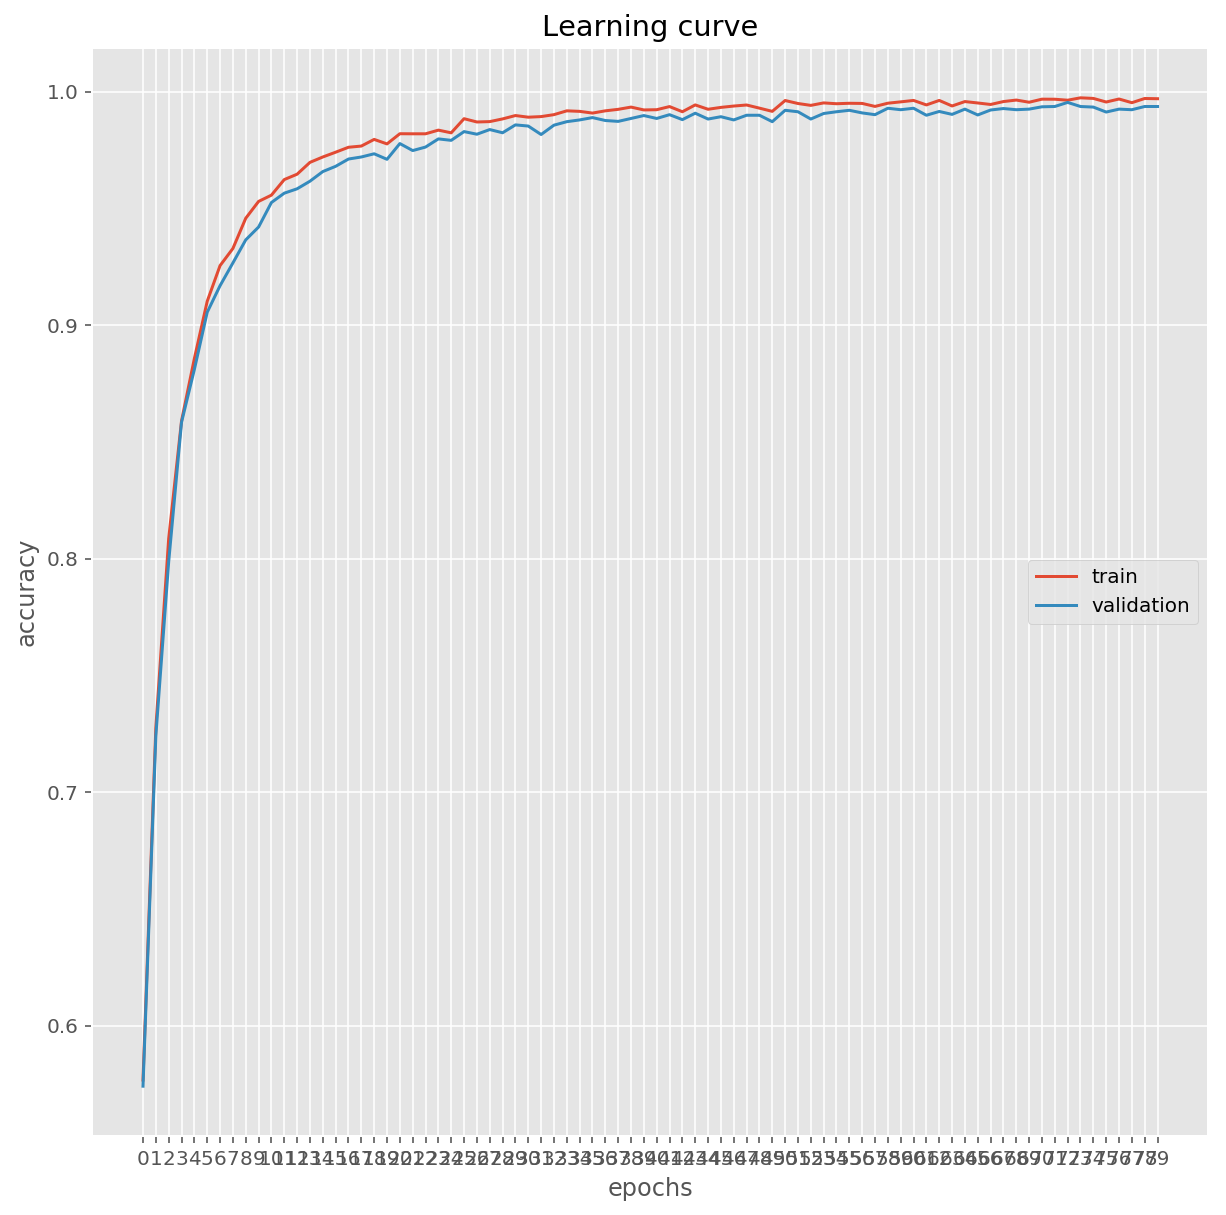

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x(), make_adam(1.0e-4)) 
    learning_curve = train_eval(pipeline, epochs=80)
    
show_learning_curve(learning_curve)

**Conclusion**:

The performance has improved.  It appears that 80 epochs are good enough to achieve great performance.  

Is this as good as it can get?

Now let's try with a dropout

In [36]:
def make_net_double2x_dropout(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
           .input(input_shape)
           .conv([5,5,24]) 
           .max_pool().relu().dropout(keep_prob=0.5)
           .conv([5,5,64]) 
           .max_pool()
           .relu().flatten().dense(480).relu().dense(N_CLASSES) 
           )


Epoch: 0 Train Score: 0.338 Evaluation Score: 0.335
Epoch: 1 Train Score: 0.485 Evaluation Score: 0.485
Epoch: 2 Train Score: 0.592 Evaluation Score: 0.593
Epoch: 3 Train Score: 0.682 Evaluation Score: 0.676
Epoch: 4 Train Score: 0.743 Evaluation Score: 0.743
Epoch: 5 Train Score: 0.792 Evaluation Score: 0.785
Epoch: 6 Train Score: 0.829 Evaluation Score: 0.826
Epoch: 7 Train Score: 0.849 Evaluation Score: 0.840
Epoch: 8 Train Score: 0.874 Evaluation Score: 0.864
Epoch: 9 Train Score: 0.886 Evaluation Score: 0.882
Epoch: 10 Train Score: 0.900 Evaluation Score: 0.898
Epoch: 11 Train Score: 0.917 Evaluation Score: 0.909
Epoch: 12 Train Score: 0.921 Evaluation Score: 0.914
Epoch: 13 Train Score: 0.935 Evaluation Score: 0.932
Epoch: 14 Train Score: 0.943 Evaluation Score: 0.934
Epoch: 15 Train Score: 0.949 Evaluation Score: 0.946
Epoch: 16 Train Score: 0.953 Evaluation Score: 0.948
Epoch: 17 Train Score: 0.958 Evaluation Score: 0.951
Epoch: 18 Train Score: 0.963 Evaluation Score: 0.956
Epo

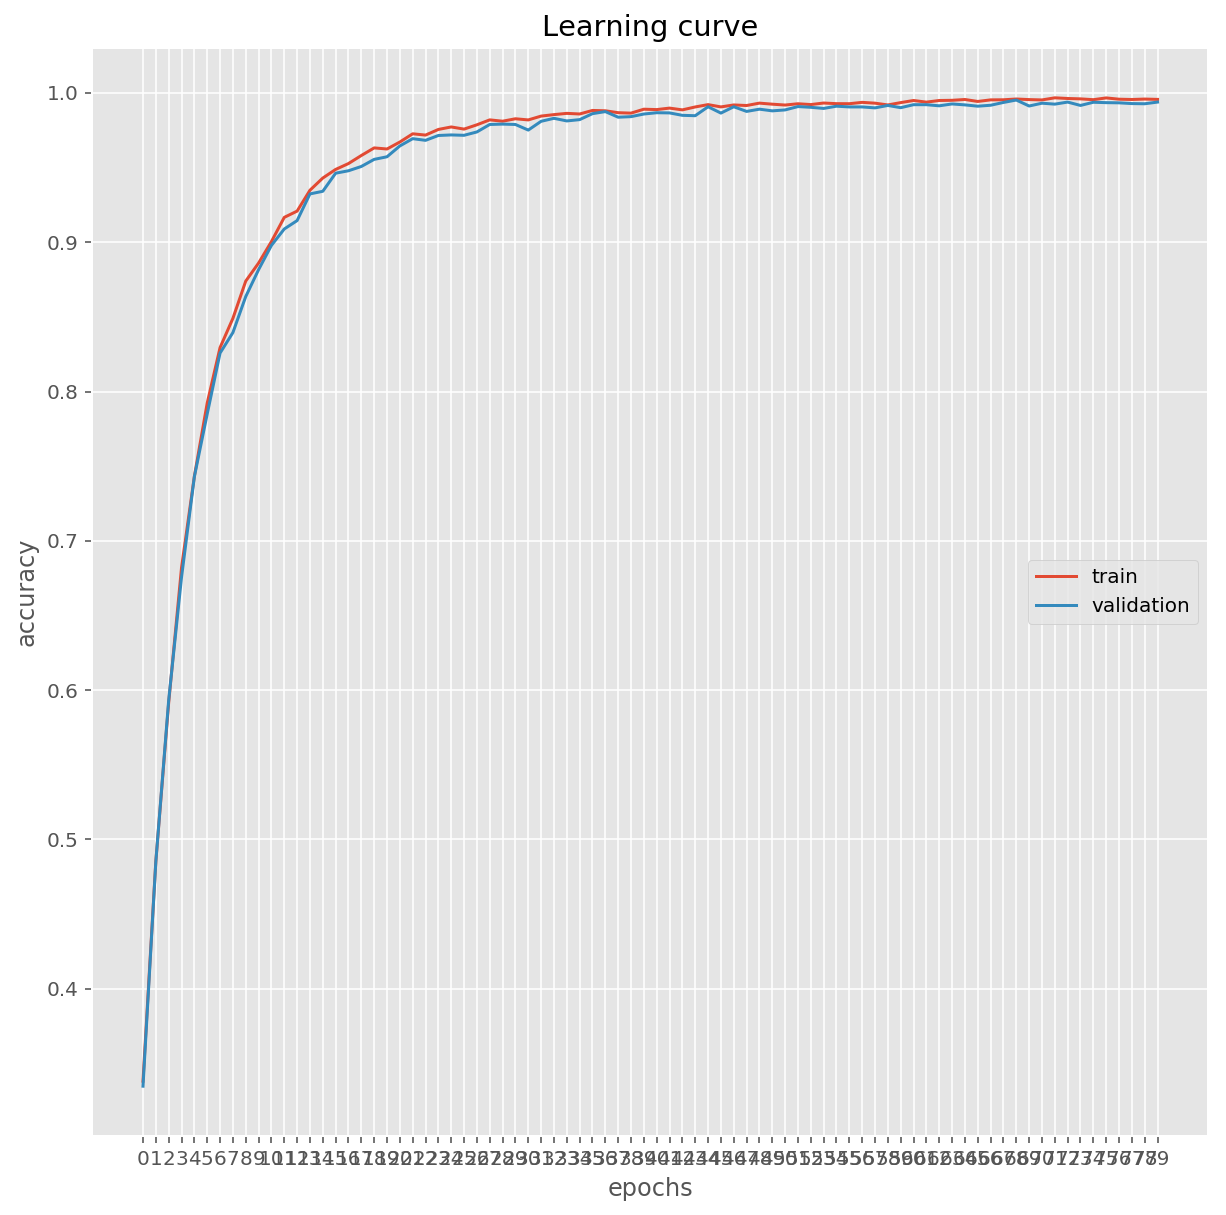

In [ ]:


with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x_dropout(), make_adam(1.0e-4)) 
    learning_curve = train_eval(pipeline, epochs=80)
    session.save('checkpoint/make_net_double2x_dropout.ckpt')
    
show_learning_curve(learning_curve)

INFO:tensorflow:Restoring parameters from checkpoint/make_net_double2x_dropout.ckpt


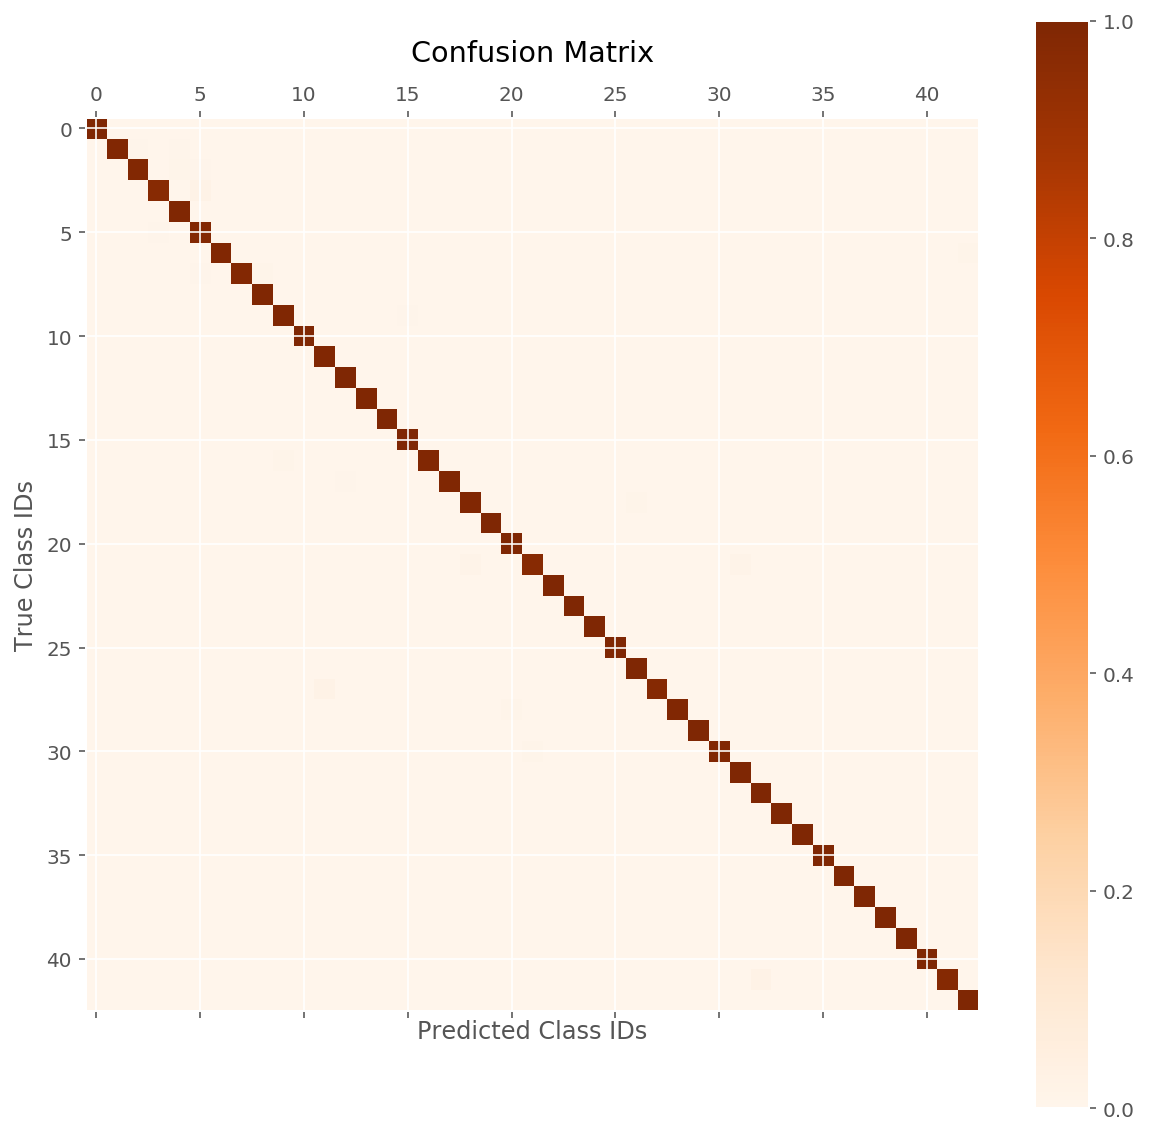

 0 Speed limit (20km/h)                               100.00%  167
10 No passing for vehicles over 3.5 metric tons       100.00% 1600
12 Priority road                                      100.00% 1672
14 Stop                                               100.00%  621
15 No vehicles                                        100.00%  501
19 Dangerous curve to the left                        100.00%  167
20 Dangerous curve to the right                       100.00%  287
22 Bumpy road                                         100.00%  310
23 Slippery road                                      100.00%  406
24 Road narrows on the right                          100.00%  215
26 Traffic signals                                    100.00%  478
29 Bicycles crossing                                  100.00%  215
31 Wild animals crossing                              100.00%  621
32 End of all speed and passing limits                100.00%  191
33 Turn right ahead                                   100.00% 

In [46]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x_dropout())
    session.load('checkpoint/make_net_double2x_dropout.ckpt')
    pred = pipeline.predict(X_valid)

cm = confusion_matrix(y_valid, pred)
show_confusion_matrix(cm)
print_confusion_matrix(cm)

**Conclusion**:

The validation performance is more stable now.

# Test Dataset

Our test dataset is located under data/Final_Test/Images

In [37]:
TEST_IMAGE_DIR = 'data/Final_Test/Images'

testdf  = pd.read_csv(os.path.join(TEST_IMAGE_DIR, 'GT-final_test.csv'), sep=';')
testdf['Filename'] = testdf['Filename'].apply(lambda x: os.path.join(TEST_IMAGE_DIR, x))
testdf.head()

Filename  Width  Height  Roi.X1  Roi.Y1  Roi.X2  \
0  data/Final_Test/Images/00000.ppm     53      54       6       5      48   
1  data/Final_Test/Images/00001.ppm     42      45       5       5      36   
2  data/Final_Test/Images/00002.ppm     48      52       6       6      43   
3  data/Final_Test/Images/00003.ppm     27      29       5       5      22   
4  data/Final_Test/Images/00004.ppm     60      57       5       5      55   

   Roi.Y2  ClassId  
0      49       16  
1      40        1  
2      47       38  
3      24       33  
4      52       11

In [38]:
print("Number of test images: {:>5}".format(testdf.shape[0]))

Number of test images: 12630


In [39]:
X_test = testdf['Filename'].values
y_test = testdf['ClassId'].values

In [40]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x_dropout())
    session.load('checkpoint/make_net_double2x_dropout.ckpt')
    score = pipeline.score(X_test, y_test)
    print('Test Score: {}'.format(score))

INFO:tensorflow:Restoring parameters from checkpoint/make_net_double2x_dropout.ckpt
Test Score: 0.9203483768804434


**Conclusion**:

It's about 92% accuracy.  For the simple network like this one, it did a really good work.

# Testing with Random Images

In [52]:
X_rnd_new = np.array(glob.glob('images/sign*.png')+glob.glob('images/sign*.jpg'))
print(str(X_rnd_new))

['images/sign10.png' 'images/sign4.png' 'images/sign8.png'
 'images/sign3.png' 'images/sign7.png' 'images/sign6.png'
 'images/sign9.png' 'images/sign5.png' 'images/sign1.jpg'
 'images/sign2.jpg']


In [53]:
new_images = [plt.imread(path) for path in X_rnd_new]
print("Random image size: "+str(X_rnd_new.shape[0]))

Random image size: 10


New Random testing images


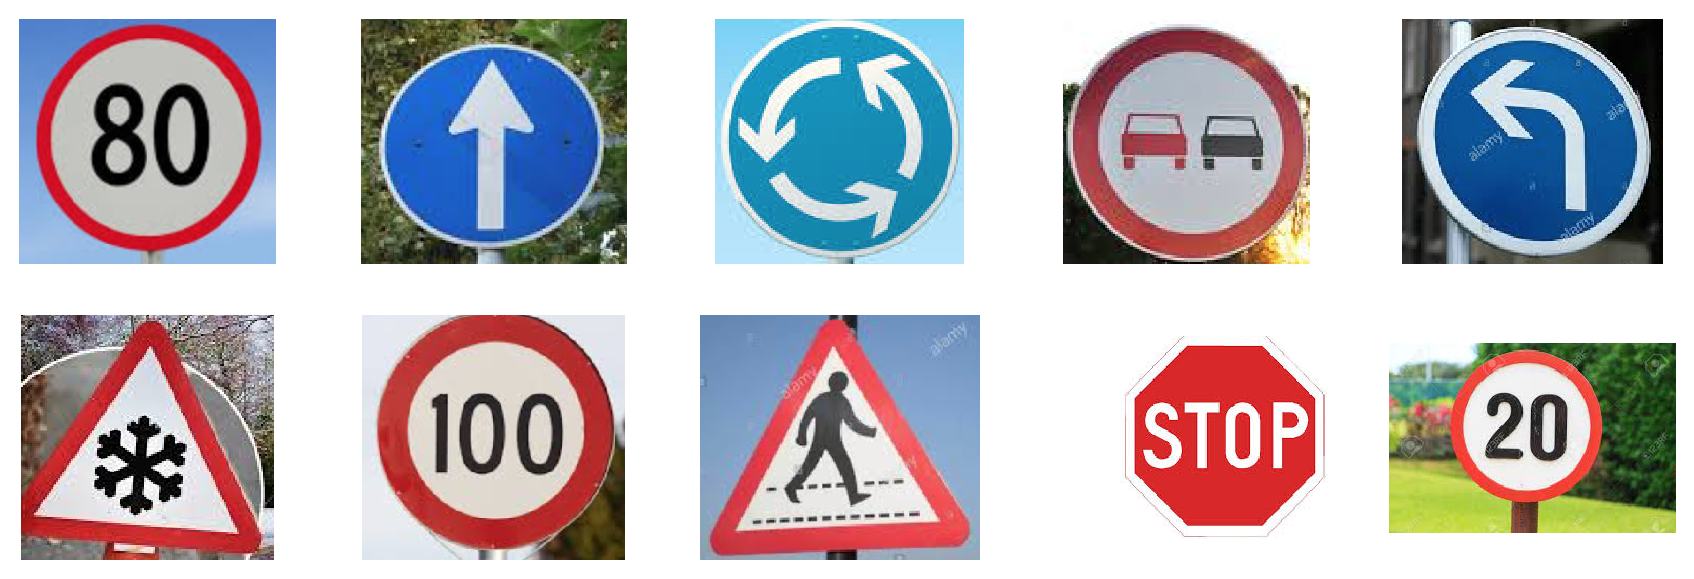

In [54]:
print('=' * 80)
print('New Random testing images')
print('=' * 80)
plt.figure(figsize=(15,5))
for i, image in enumerate(new_images):
    plt.subplot(2,len(new_images)//2,i+1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])    
plt.show()

In [55]:
print('Show Top 5 results')
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x_dropout())
    session.load('checkpoint/make_net_double2x_dropout.ckpt')  
    prob = pipeline.predict_proba(X_rnd_new)
    estimator = pipeline.steps[-1][1]
    top_5_prob, top_5_pred = estimator.top_k_
print('done')

Show Top 5 results
INFO:tensorflow:Restoring parameters from checkpoint/make_net_double2x_dropout.ckpt
done


Top 5 Predictions


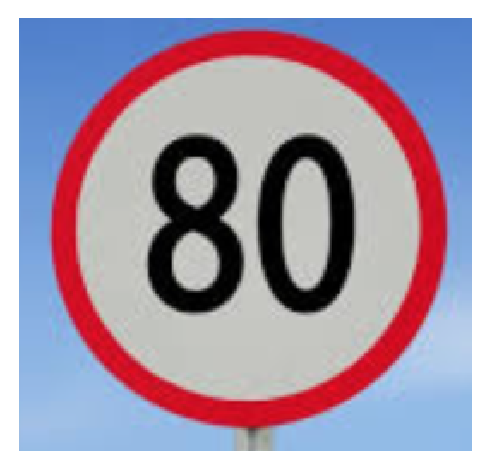

    5: Speed limit (80km/h)                               ( 61.9222581387%)
    3: Speed limit (60km/h)                               ( 20.8162441850%)
    2: Speed limit (50km/h)                               (  9.9365964532%)
   20: Dangerous curve to the right                       (  4.1637748480%)
   28: Children crossing                                  (  2.5099148974%)
--------------------------------------------------------------------------------


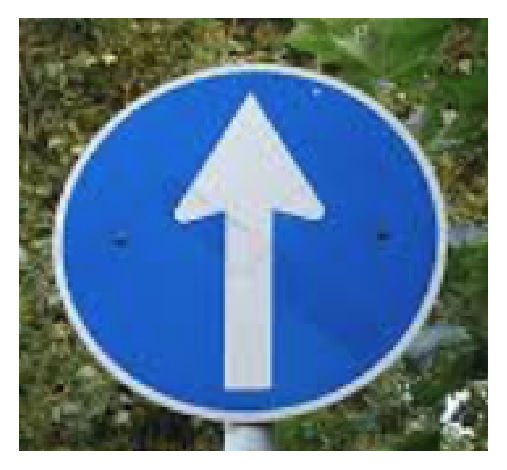

   35: Ahead only                                         (100.0000000000%)
   36: Go straight or right                               (  0.0000000000%)
   37: Go straight or left                                (  0.0000000000%)
   33: Turn right ahead                                   (  0.0000000000%)
   34: Turn left ahead                                    (  0.0000000000%)
--------------------------------------------------------------------------------


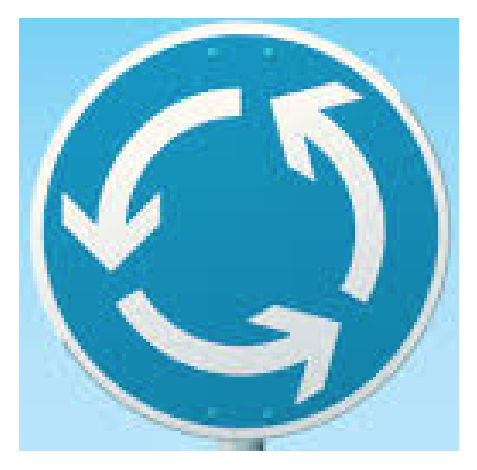

   40: Roundabout mandatory                               (100.0000000000%)
   38: Keep right                                         (  0.0000000070%)
   36: Go straight or right                               (  0.0000000000%)
   34: Turn left ahead                                    (  0.0000000000%)
   39: Keep left                                          (  0.0000000000%)
--------------------------------------------------------------------------------


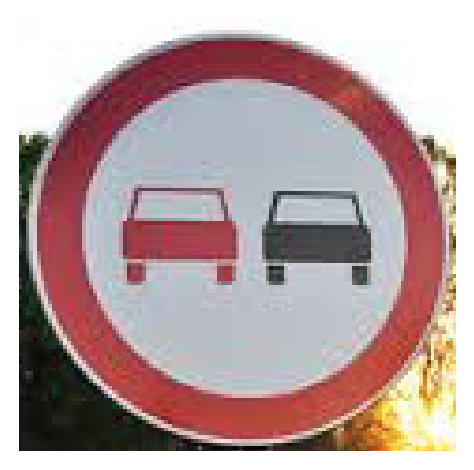

    9: No passing                                         ( 49.4763672352%)
   41: End of no passing                                  ( 29.2696416378%)
   15: No vehicles                                        ( 21.2396800518%)
   10: No passing for vehicles over 3.5 metric tons       (  0.0095076495%)
   16: Vehicles over 3.5 metric tons prohibited           (  0.0046090790%)
--------------------------------------------------------------------------------


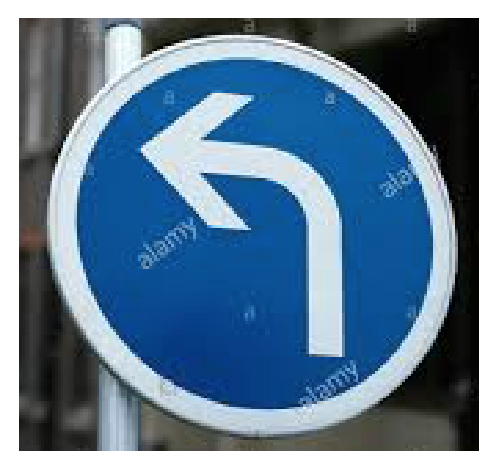

   34: Turn left ahead                                    ( 99.8095810413%)
   38: Keep right                                         (  0.1447550487%)
   40: Roundabout mandatory                               (  0.0456601032%)
   35: Ahead only                                         (  0.0000003741%)
   37: Go straight or left                                (  0.0000000006%)
--------------------------------------------------------------------------------


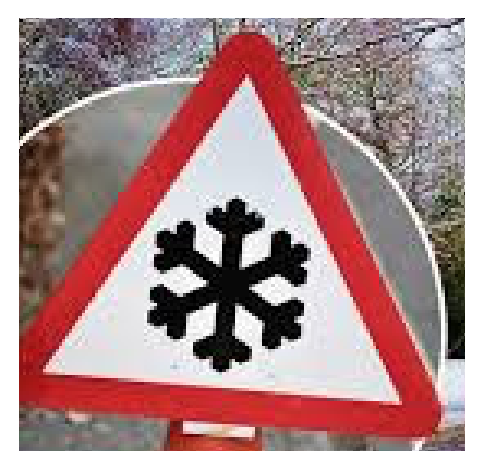

   30: Beware of ice/snow                                 ( 88.5518968105%)
   28: Children crossing                                  ( 11.4465177059%)
   11: Right-of-way at the next intersection              (  0.0012830817%)
   29: Bicycles crossing                                  (  0.0001776658%)
   25: Road work                                          (  0.0000457331%)
--------------------------------------------------------------------------------


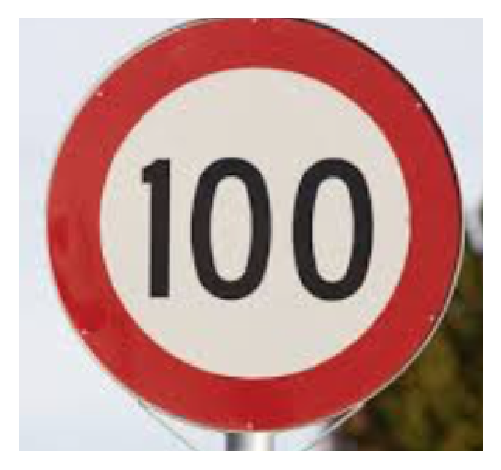

    5: Speed limit (80km/h)                               ( 97.5017309189%)
    2: Speed limit (50km/h)                               (  2.3713797331%)
    3: Speed limit (60km/h)                               (  0.1152099227%)
    7: Speed limit (100km/h)                              (  0.0078745885%)
    1: Speed limit (30km/h)                               (  0.0019132347%)
--------------------------------------------------------------------------------


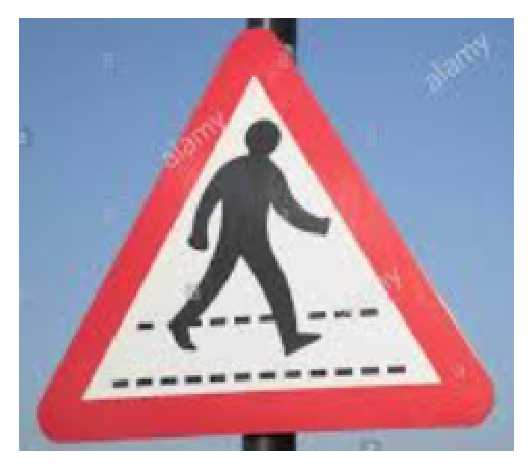

   25: Road work                                          ( 97.7592527866%)
   18: General caution                                    (  1.7660886049%)
   27: Pedestrians                                        (  0.4230289720%)
   20: Dangerous curve to the right                       (  0.0310283795%)
   21: Double curve                                       (  0.0112261885%)
--------------------------------------------------------------------------------


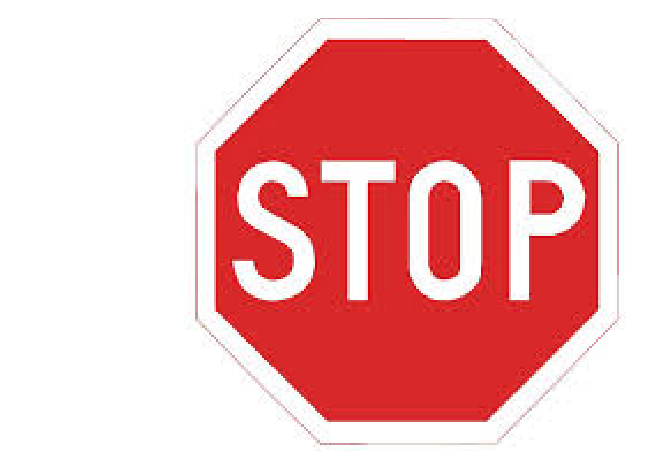

   14: Stop                                               (100.0000000000%)
   17: No entry                                           (  0.0000017292%)
    0: Speed limit (20km/h)                               (  0.0000000372%)
    1: Speed limit (30km/h)                               (  0.0000000000%)
    2: Speed limit (50km/h)                               (  0.0000000000%)
--------------------------------------------------------------------------------


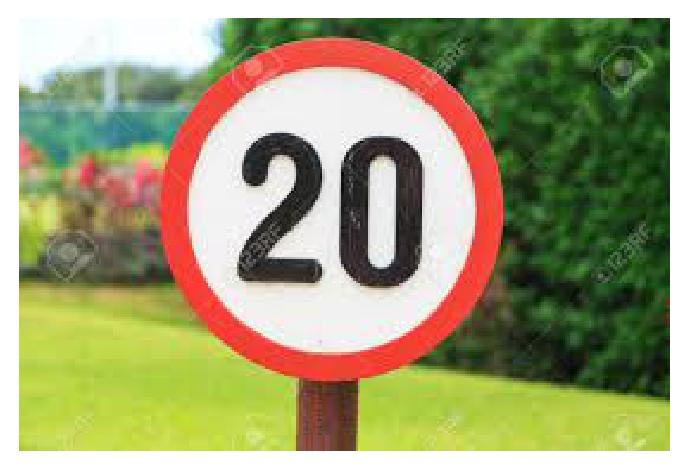

   20: Dangerous curve to the right                       ( 64.0886843204%)
    3: Speed limit (60km/h)                               ( 13.4701445699%)
   26: Traffic signals                                    ( 13.2238760591%)
   11: Right-of-way at the next intersection              (  3.3252578229%)
   23: Slippery road                                      (  1.3853384182%)
--------------------------------------------------------------------------------


In [56]:
print('=' * 80)
print('Top 5 Predictions')
print('=' * 80)
for i, (preds, probs, image) in enumerate(zip(top_5_pred, top_5_prob, new_images)):
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    for pred, prob in zip(preds.astype(int), probs):
        sign_name = SIGN_NAMES[pred]
        print('{:>5}: {:<50} ({:>14.10f}%)'.format(pred, sign_name, prob*100.0))
    print('-' * 80)    

# Conclusion

The use of pipelines were very effective during the experimentations.  In the end, the traffic sign classifier works pretty well overall with the test set.  

If a self-driving car needs to find traffic signs in public, it needs to find out first where the traffic signs are.  It's a chicken and egg problem.